In [1]:

import numpy as np
import matplotlib.pylab as plt
import glob
from datetime import datetime, timedelta
import sys
import xarray as xr
from matplotlib import rc
import matplotlib.animation as animation
import matplotlib as mpl
import cartopy.crs as ccrs
import os
import cartopy
from scipy.sparse import csr_matrix, load_npz, save_npz
import scipy.sparse.linalg as sla
import cmocean
from scipy import stats



from timeit import default_timer as timer



In [2]:
sys.path.insert(0,'.')    # '.' is in the same folder
%load_ext autoreload
%autoreload 1
#  Reload all modules imported with %aimport every time before executing the Python code typed.

# %cd /home/students/6252699/thesis/parcels2/
%aimport advect_ice_every_day_bering
%aimport plot_functions
%aimport transition_matrices
%aimport advect_test


%matplotlib inline
%reload_ext autoreload

import functions.lay_out
plt.style.use(['default'])
from functions.distance import great_circle

In [3]:
data_dir = "/science/projects/oceanparcels/CMEMS-GLORYS12V1-Arctic/"
out_dir = "/scratch/AnnekeV/output/single_particles/"
home    = "/home/students/6252699/thesis/parcels2/"

# --------------------------------------------------------------------------
# Functions
# --------------------------------------------------------------------------

In [4]:
def find_final_section(ds, lat1, lat2, lon1, lon2):
    '''
    ds = dataset
    lon1 and lon2 between -180, +180
    '''
    lon = ds.lon.isel(obs=-1)
    lat = ds.lat.isel(obs=-1)
    if lon2<lon1:
        lon2+=360
        lon = lon.where(lon>=0, lon +360)
    indices     =  np.where((lat >lat1 )& (lat <lat2) & (lon >lon1 )& (lon <lon2))[0]
    return indices



In [5]:
'''Shift the thing backward'''
def shift_nans(outputname):
    "Make sure it is outputname without .nc"
    fn = outputname + ".nc"
    ds = xr.open_dataset(fn, decode_times=False)

    npart  = len(ds.traj)


    for key, value in ds.iteritems():
        print(key)
        mat = ds[key].values.copy()
        if key == "trajectory": continue

        for i in range(1,npart):
            data        = mat[i,:-i].copy()
            mat[i,:]    = np.nan
            mat[i,i:]   = data

        ds[key].values  = mat

    ds.time.plot()
    ds.to_netcdf(outputname + "shifted.nc")

# shift_nans(output_2800_ocean)

# --------------------------------------------------------------------------
# Main
# --------------------------------------------------------------------------

# Specific functions

In [41]:



def set_background(ax, coastlines = False):

    ymin, ymax = 50,80
    xmin, xmax = -180,180

    ax.gridlines(xlocs = np.arange(-180,185,dlon), ylocs = np.arange(0,90,dlat), color='black', alpha=0.5, linestyle=':')
#     ax.add_feature(cartopy.feature.OCEAN)
    if coastlines:
        ax.add_feature(plot_functions.land_50m, edgecolor='black')
    else:
        ax.add_feature(plot_functions.land_50m)
    ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())
    plot_functions.set_circular_boundary(ax)
    return ax


def fill_with_background(ax, ds,  histogram_data,  bounds, dlat, dlon,  type_operation = "mean", cbar_label = 'Nr. times into ice'):

    ds_short    = ds
    nr_times_in_ice = histogram_data
    npart       = np.size(ds.lon,0)
    length      = np.size(ds.lon,1)
    
    lats        = np.arange(50,90, dlat)
    lons        = np.arange(-180,180,dlon)

    cmap        = plt.cm.plasma  # define the colormap
    cmaplist    = [cmap(i) for i in range(cmap.N)]
    cmap_custom = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)  # in case you want to edit a color
    norm        = mpl.colors.BoundaryNorm(bounds, cmap_custom.N)


    means = np.zeros([len(lats), len(lons)])

    '''Calculate and fill all the boxes'''
    for i in range(len(lats)):
        lat1 = lats[i]
        lat2 = lat1+dlat
        for j in range(len(lons)):
            lon1 = lons[j]
            lon2 = lon1+dlon    
            indices = find_final_section(ds_short, lat1, lat2, lon1, lon2)
            
            if  type_operation == "mean":
                means[i,j] = np.mean(nr_times_in_ice[indices])
            else: 
                print("Change type operation to mean")
                
            if np.isnan(means[i,j]): 
                percent= np.nan
            else: 
                percent = int(means[i,j]/np.max(bounds)*cmap.N)
                if percent >= cmap.N: percent = cmap.N-1
                fill = ax.fill_between(np.linspace(lon1,lon2, 100), np.linspace(lat1,lat1,100), np.linspace(lat2,lat2,100), transform=ccrs.PlateCarree(), color = cmaplist[percent])


    '''Find North pole section'''
    lat1, lat2 = 90.-dlat, 90.
    lon1, lon2 = -200., 200.
    indices    = find_final_section(ds_short, lat1, lat2, lon1, lon2)
    
    if type_operation == "mean": 
        means_np   = np.mean(nr_times_in_ice[indices])
    if np.isnan(means_np): percent= np.nan
    else: 
        percent = int(means[i,j]/np.max(bounds)*cmap.N)
        if percent >= cmap.N: percent = cmap.N-1
        fill = ax.fill_between(np.linspace(lon1,lon2, 100), np.linspace(lat1,lat1,100), np.linspace(lat2,lat2,100), transform=ccrs.PlateCarree(), color = cmaplist[percent])

        
    '''create a second axes for the colorbar'''
    ax_cbar = fig_kaart.add_axes([0.95, 0.1, 0.03, 0.8])
    cb      = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap_custom, norm=norm, spacing='uniform', ticks=bounds, boundaries=bounds, format='%.1f', extend="max")
    ax_cbar.set_ylabel(cbar_label, size=12)

    return ax, means

In [90]:
def count_per_section(dataset, tobesorted, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=False, npart=10950):
    '''
    counts divided in 3 sections. 
    dataset must be netcdf file
    to be sorted is the output, one variable of the dataset
    lon_arc, to lat_pac are arrays with minimum and maximum longitude or latitude
    non_nans shoud be true if you suspect particles left domain, than it extracts the last position that was in the domain
    npart = number of particles 
    '''
    
    final_lons = dataset.lon.isel(obs=-1)
    final_lats = dataset.lat.isel(obs=-1)
    
    if non_nans:
        final_lons = np.zeros(npart)
        final_lats = np.zeros(npart)
        for i in range(npart):
            lons     = dataset.lon.values[i,:]
            lats     = dataset.lat.values[i,:]
            final_lons[i] = lons[~np.isnan(lons)][-1]
            final_lats[i] = lats[~np.isnan(lats)][-1]

    nr_arc = tobesorted[(final_lats>=lat_arc[0])]
    nr_atl = tobesorted[((final_lons<lon_atl[1]) & (final_lons>lon_atl[0]) & (final_lats<lat_arc[0]))]
    nr_pac = tobesorted[~((final_lons<lon_atl[1]) & (final_lons>lon_atl[0]))& (final_lats<lat_arc[0])]  #not in atlantic

    return nr_arc, nr_atl, nr_pac

a, b, c  = count_per_section(be_ice, be_ice.lon.isel(obs=-1).values, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=True)
print (len(a), len(b), len(c), 10950-(len(a)+len(b)+len(c)))

(9207, 33, 1710, 0)


In [112]:
def make_histogram_four(bins_histo, alles, arctic, atlantic, pacific, label):
    
    fig = plt.figure(figsize = [6,9])
    
    ax1 = fig.add_subplot(4,1,1)
    ax1.hist(alles, bins=bins_histo, rwidth=.6, color='black')
    ax1.set_title("All", fontstyle = 'italic', fontsize= 12)


    ax2 = fig.add_subplot(4,1,2,  sharex=ax1)
    ax2.hist(arctic, bins=bins_histo, rwidth=.6, color='cornflowerblue')
    ax2.set_title("Arctic", fontstyle = 'italic', fontsize= 12)

    ax3 = fig.add_subplot(4,1,3,  sharex=ax1)
    ax3.hist(atlantic, bins=bins_histo, rwidth=.6, color='forestgreen')
    ax3.set_title("Atlantic", fontstyle = 'italic', fontsize= 12)

    ax4 = fig.add_subplot(4,1,4,  sharex=ax1)
    ax4.hist(pacific, bins=bins_histo, rwidth=.6, color='palevioletred')
    ax4.set_title("Pacific ", fontstyle = 'italic', fontsize= 12)
    ax4.set_xlim([0,np.max(bins_histo)])
    ax4.set_xticks(np.linspace(0, np.max(bins_histo),11, dtype=int))
    ax4.set_xlabel(label)

    fig.subplots_adjust(hspace=.4)

    return fig


def make_histogram_four_no_sections(bins_histo, all_data, ds_locs, label, print_amount=False):
    
    arctic, atlantic, pacific = count_per_section(ds_locs, all_data, 
                                                  lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac)
    
    
    if print_amount:
        print("Total  = {}".format(len(all_data)))
        print("Arctic = {}".format(len(arctic)))
        print("Atlant = {}".format(len(atlantic)))
        print("Pacifi = {}".format(len(pacific)))

   
    fig = plt.figure(figsize = [6,9])
    
    ax1 = fig.add_subplot(4,1,1)
    ax1.hist(all_data, bins=bins_histo, rwidth=.6, color='black')
    ax1.set_title("All", fontstyle = 'italic', fontsize= 12)
#     ax1.set_ylabel("Number of occurences")


    ax2 = fig.add_subplot(4,1,2,  sharex=ax1)
    ax2.hist(arctic, bins=bins_histo, rwidth=.6, color='cornflowerblue')
    ax2.set_title("Arctic", fontstyle = 'italic', fontsize= 12)
    ax2.set_ylabel("Number of occurences")

    
    ax3 = fig.add_subplot(4,1,3,  sharex=ax1)
    ax3.hist(atlantic, bins=bins_histo, rwidth=.6, color='forestgreen')
    ax3.set_title("Atlantic", fontstyle = 'italic', fontsize= 12)
#     ax3.set_ylabel("Nr. occurences", fontsize =8)


#     if len(pacific>0):
    ax4 = fig.add_subplot(4,1,4,  sharex=ax1)
    ax4.hist(pacific, bins=bins_histo, rwidth=.6, color='palevioletred')
    ax4.set_title("Pacific ", fontstyle = 'italic', fontsize= 12)
    ax4.set_xlim([0,np.max(bins_histo)])
    ax4.set_xticks(np.linspace(0, np.max(bins_histo),11, dtype=int))
    ax4.set_xlabel(label)
#     ax4.set_ylabel("Nr. occurences", fontsize =8)
#     else: 
#         ax3.set_xlim([0,np.max(bins_histo)])
#         ax3.set_xticks(np.linspace(0, np.max(bins_histo),11, dtype=int))
#         ax3.set_xlabel(label)
 

    fig.subplots_adjust(hspace=.4)

    return fig





In [9]:
def make_pdf(data, xx):
    '''
    Makes a probability density function based on the gaussian kernel density distribution
    Data = data
    xx  = array for what you want to plot pdf
    '''
    kde = stats.gaussian_kde(data)
    return kde(xx)

# lay out


In [10]:
import matplotlib as mpl
plt.style.use(['default'])

################################################################

# plotting parameters
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams["figure.figsize"] = [8 , 4]
mpl.rcParams['legend.fontsize'] = 12      #legend size
#title params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.style'] = 'italic'    #all fonts italic
#axes params
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 13
# line width and grid
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams["axes.grid"] = 1
# mpl.rcParams["figure.subplot.left"] = 0.05
# mpl.rcParams["figure.subplot.right"] = 0.1
# mpl.rcParams["figure.subplot.bottom"] = 0.11
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.1
mpl.rcParams['legend.loc'] =  'best'

# colors
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


BERING
==================================

In [11]:
length = 1700

In [12]:
data_dir = "/science/projects/oceanparcels/CMEMS-GLORYS12V1-Arctic/"
out_dir = "/scratch/AnnekeV/output/single_particles/ten_per_day/"
home    = "/home/students/6252699/thesis/parcels2/"

In [13]:
glob.glob(out_dir + "*bering*ocean*.nc")[0]


'/scratch/AnnekeV/output/single_particles/ten_per_day/bering-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_ocean_dtdays_1_10_at_a_time.nc'

In [14]:
be_ice = glob.glob(out_dir + "*bering*prob*.nc")[0]
be_ice = xr.open_dataset(be_ice, decode_times=False)
be_ice = be_ice.isel(obs=np.arange(length))

In [15]:
be_ocean = glob.glob(out_dir + "*bering*ocean*.nc")[0]
be_ocean = xr.open_dataset(be_ocean, decode_times=False)
be_ocean = be_ocean.isel(obs=np.arange(length))
be_ocean

<xarray.Dataset>
Dimensions:     (obs: 1700, traj: 10950)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 ...
    time        (traj, obs) float64 ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    sic         (traj, obs) float32 ...
    in_ice      (traj, obs) float32 ...
    sit         (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.0.0b0
    parcels_mesh:           spherical

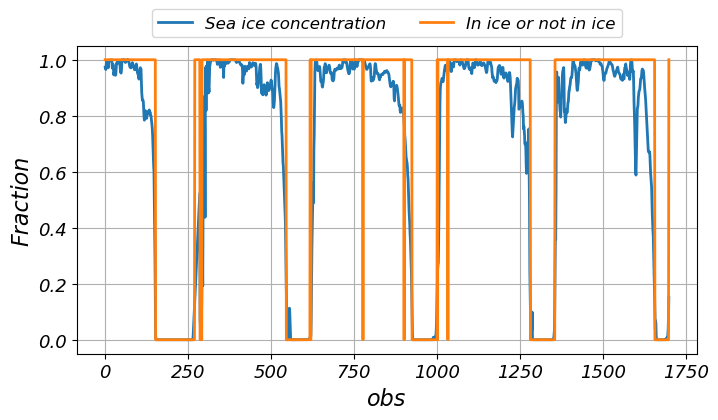

In [20]:
ds = be_ice
plt.figure()
ds.sic.isel(traj=0).plot(label = "Sea ice concentration")
ds.in_ice.isel(traj=0).plot(label = "In ice or not in ice")
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5,1), ncol=2)
plt.ylabel("Fraction")
dlat, dlon = 10, 20 


# Cut off

In [17]:
npart    = np.size(be_ice.sic,0)


Text(0.5,0,'Nr days in ice')

<Figure size 800x400 with 0 Axes>

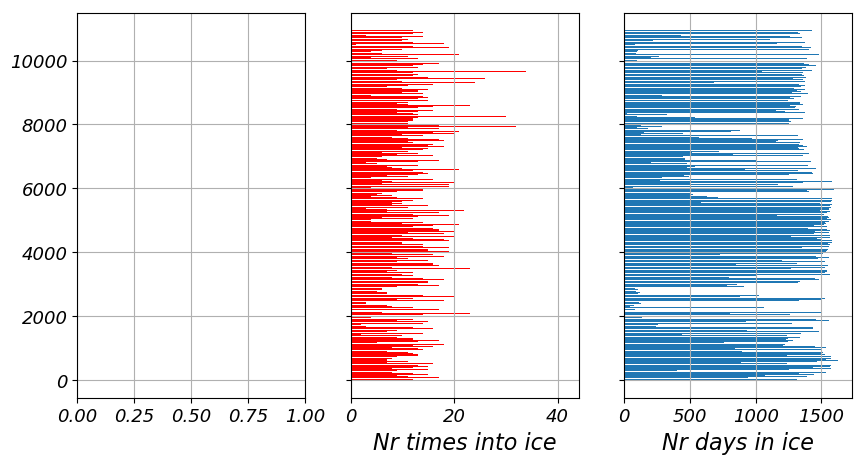

In [119]:
'''Find how often stuff goes in and out ice'''


in_ice          = be_ice.in_ice
nr_times_in_ice = np.zeros(npart)
nr_days_in_ice  = in_ice.sum('obs')
# in_ice = in_ice.where(in_ice.traj<200,1)

for p in range(npart):
    in_out             = (in_ice.isel(traj=p)[1:]-in_ice.isel(traj=p)[:-1])
    nr_times_in_ice[p] = np.sum(in_out[in_out>0])+ in_ice.isel(traj=p).isel(obs=0)

    
fig = plt.figure()
f , (ax1, ax2, ax3)= plt.subplots(1,3, sharey=True, figsize = (10,5))
# in_ice.plot(ax=ax1, add_colorbar= False)
ax2.barh(np.arange(npart),nr_times_in_ice, label = "Nr times into ice", color = 'red')
ax3.barh(np.arange(npart),nr_days_in_ice, label = "Nr days in ice")
ax2.set_xlabel("Nr times into ice")
ax3.set_xlabel("Nr days in ice")

Text(0.5,1,'After 1700 days \nmean nr into ice per region')

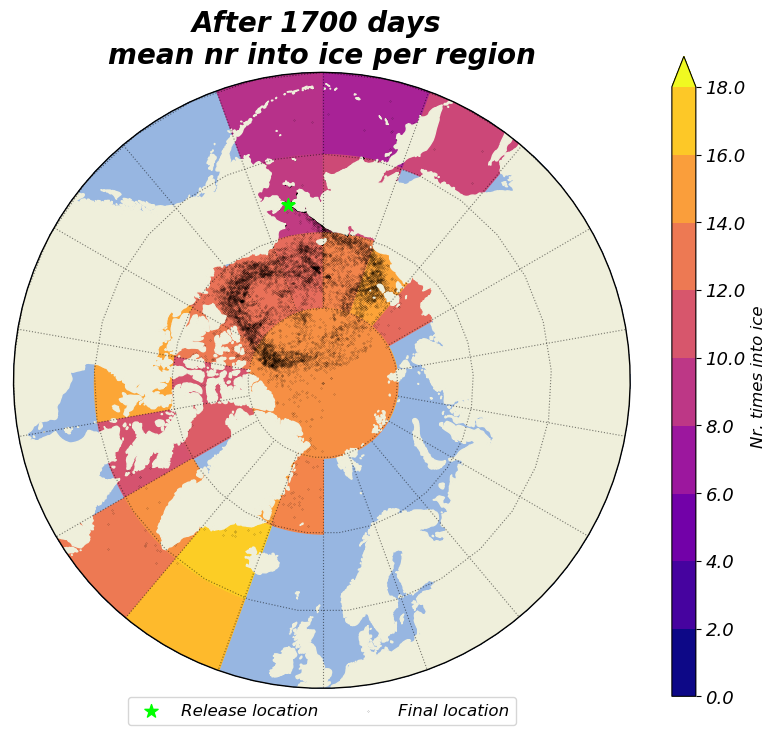

In [58]:
dlat, dlon = 10, 20 
bins_times   = np.arange(0,22., 2.)



fig_kaart = plt.figure(figsize = [8,8])
ax        = fig_kaart.add_subplot(1,1, 1, projection=ccrs.NorthPolarStereo())
ax        = set_background(ax)


ax, means = fill_with_background(ax=ax, ds=be_ice, histogram_data=nr_times_in_ice, bounds=bins_times, dlat=dlat, dlon=dlon)


'''scatter points'''
a = ax.scatter(be_ice.lon.isel(obs=0).isel(traj=0), be_ice.lat.isel(obs=0).isel(traj=0), marker='*', transform=ccrs.PlateCarree(), color = "lime", s=1e2, label = "Release location", zorder = 10)
s = ax.scatter(be_ice.lon.isel(obs=-1), be_ice.lat.isel(obs=-1), transform=ccrs.PlateCarree(), color = "black", s=.01, label = "Final location")

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 0), ncol=2)
ax.set_title("After {} days \nmean nr into ice per region" .format(length))

# plt.savefig("figures/trajectories/nr_times_in_ice_bering_10_a_day.png")

Text(0.5,1,'After 1700 days \nmean nr days ice per region')

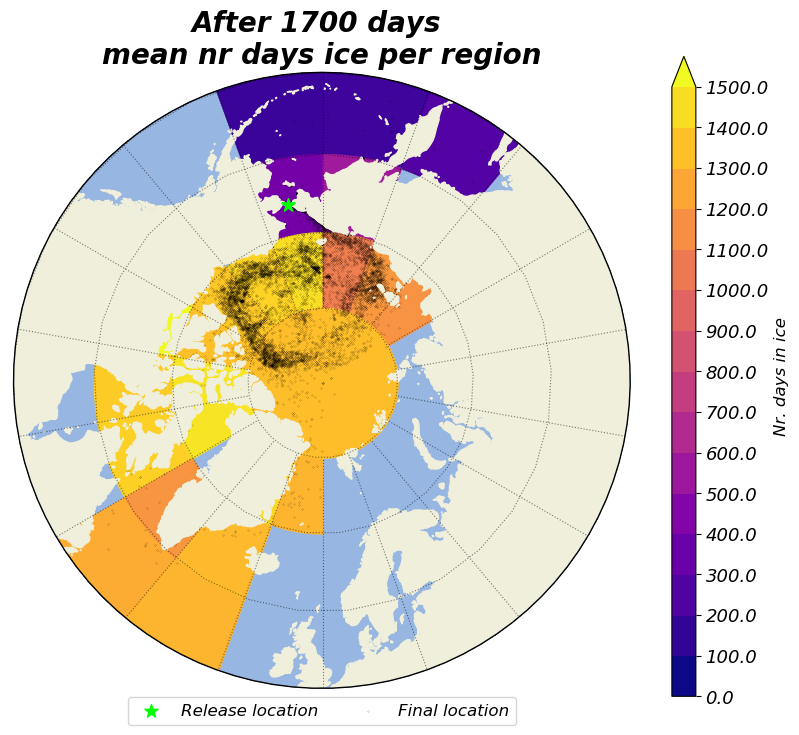

In [59]:
dlat, dlon  = 10, 20 
bins_days   = np.arange(0,1700., 100.)



fig_kaart = plt.figure(figsize = [8,8])
ax        = fig_kaart.add_subplot(1,1, 1, projection=ccrs.NorthPolarStereo())
ax        = set_background(ax)


ax, means = fill_with_background(ax=ax, ds=be_ice, histogram_data=nr_days_in_ice, bounds=bins_days, dlat=dlat, dlon=dlon, cbar_label="Nr. days in ice")


'''scatter points'''
a = ax.scatter(be_ice.lon.isel(obs=0).isel(traj=0), be_ice.lat.isel(obs=0).isel(traj=0), marker='*', transform=ccrs.PlateCarree(), color = "lime", s=1e2, label = "Release location", zorder = 10)
s = ax.scatter(be_ice.lon.isel(obs=-1), be_ice.lat.isel(obs=-1), transform=ccrs.PlateCarree(), color = "black", s=.01, label = "Final location")
# s = ax.scatter(ds_shifted.lon.isel(obs=-1), ds_shifted.lat.isel(obs=-1), transform=ccrs.PlateCarree(), color = "white", s=.5, label = "Final location")

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 0), ncol=2)
ax.set_title("After {} days \nmean nr days ice per region" .format(length))

# plt.savefig("figures/trajectories/nr_days_in_ice_bering_10_a_day.png")

# To check if first thing is corrrect

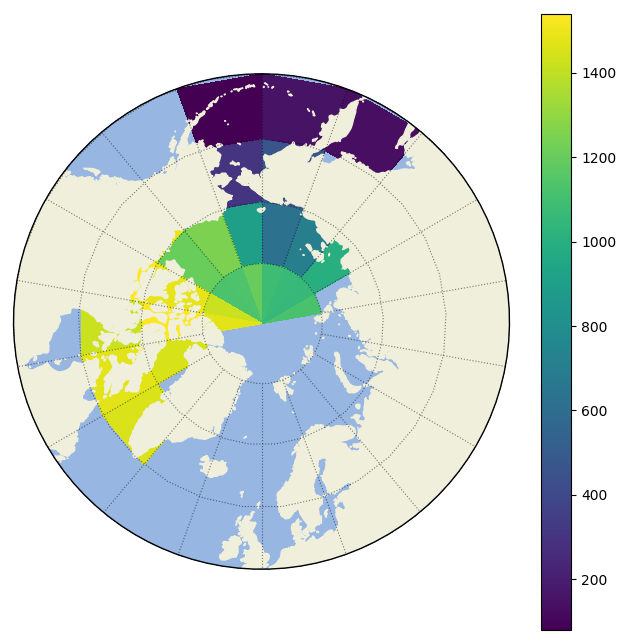

In [24]:
fig_kaart_mesh = plt.figure(figsize = [8,8])
ax2 = fig_kaart_mesh.add_subplot(1,1, 1, projection=ccrs.NorthPolarStereo())
ax2 = set_background(ax2)
p =ax2.pcolormesh(np.arange(-180,180+dlon,dlon), np.arange(50,90+dlat,dlat), means, transform=ccrs.PlateCarree())
plt.colorbar(p)

## Description of different sections:

So first of all, let's define the Arctic. Let's say everythoing above 68 N. 

For low latitudes we have two sections

We have the Atlantic section:
-120 to +100

And Pacific is the rest.

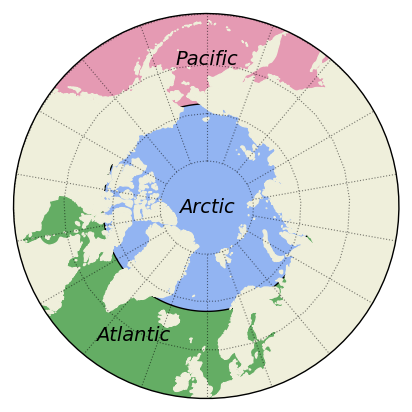

In [104]:
arctic_line = 68

lon_arc = [-180,180]
lat_arc = [arctic_line, 90]

lon_atl = [-120,100]
lat_atl = [50,arctic_line]

lon_pac = [100, 360-120]
lat_pac = [50,arctic_line]

fig_sections = plt.figure(figsize = [5,5])
ax = fig_sections.add_subplot(1,1, 1, projection=ccrs.NorthPolarStereo())
ax = set_background(ax)


'''Arctic'''
ax.fill_between(np.linspace(lon_arc[0],lon_arc[1], 100), np.linspace(lat_arc[0], lat_arc[0],100), np.linspace(lat_arc[1],lat_arc[1],100), 
                transform=ccrs.PlateCarree(), facecolor = "cornflowerblue", edgecolor="None", zorder = 1, alpha = .7)
ax.text(0,90,"Arctic", ha='center', va='center', transform=ccrs.PlateCarree(), zorder = 1)


'''Atlantic'''
ax.fill_between(np.linspace(lon_atl[0],lon_atl[1], 100), np.linspace(lat_atl[0], lat_atl[0],100), np.linspace(lat_atl[1],lat_atl[1],100), 
                transform=ccrs.PlateCarree(), facecolor = "forestgreen", edgecolor="None", zorder = 1, alpha = .7)
ax.text(-30,np.mean(lat_atl),"Atlantic", ha='center', va='center', transform=ccrs.PlateCarree(), zorder = 10)

'''Pacific'''
ax.fill_between(np.linspace(lon_pac[0],lon_pac[1], 100), np.linspace(lat_pac[0], lat_pac[0],100), np.linspace(lat_atl[1],lat_atl[1],100), 
                transform=ccrs.PlateCarree(), facecolor = "palevioletred", edgecolor="None", zorder = 1, alpha = .7)
ax.text(180,np.mean(lat_pac),"Pacific", ha='center', va='center', transform=ccrs.PlateCarree(), zorder = 20)

ax.plot(np.linspace(lon_arc[0],lon_arc[1], 1000),np.linspace(lat_arc[0], lat_arc[0],1000), color = 'black', transform= ccrs.Geodetic(), zorder=1, linewidth=1)

plt.savefig(home + "figures/sections.png")


In [ ]:
nr_arc, nr_atl, nr_pac = count_per_section(be_ice, nr_times_in_ice, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac)

bins_histo = np.arange(-.5, 50.5,1)

fig = plt.figure(figsize = [6,9])
ax1 = fig.add_subplot(4,1,1)
ax1.hist(nr_times_in_ice, bins=bins_histo, rwidth=.6, color='black')
ax1.set_xlim([0,18])
ax1.set_title("All", fontstyle = 'italic', fontsize= 12)


ax2 = fig.add_subplot(4,1,2,  sharex=ax1)
ax2.hist(nr_arc, bins=bins_histo, rwidth=.6, color='cornflowerblue')
ax2.set_title("Arctic", fontstyle = 'italic', fontsize= 12)

ax3 = fig.add_subplot(4,1,3,  sharex=ax1)
ax3.hist(nr_atl, bins=bins_histo, rwidth=.6, color='forestgreen')
ax3.set_title("Atlantic", fontstyle = 'italic', fontsize= 12)

ax4 = fig.add_subplot(4,1,4,  sharex=ax1)
ax4.hist(nr_pac, bins=bins_histo, rwidth=.6, color='palevioletred')
ax4.set_title("Pacific ", fontstyle = 'italic', fontsize= 12)
ax4.set_xlim([0,50])
ax4.set_xticks(np.arange(0, 50,5))
ax4.set_xlabel("Nr. times in ice")
    
fig.subplots_adjust(hspace=.4)
fig.suptitle("Histogram per section")



plt.savefig("/home/students/6252699/thesis/parcels2/figures/trajectories/hist_nr_times_in_ice.png", bbox_inches="tight", pad_inches=0.1)

# MAKE PROBABILITY DENSITY FUNCTION

## for nr times into ice

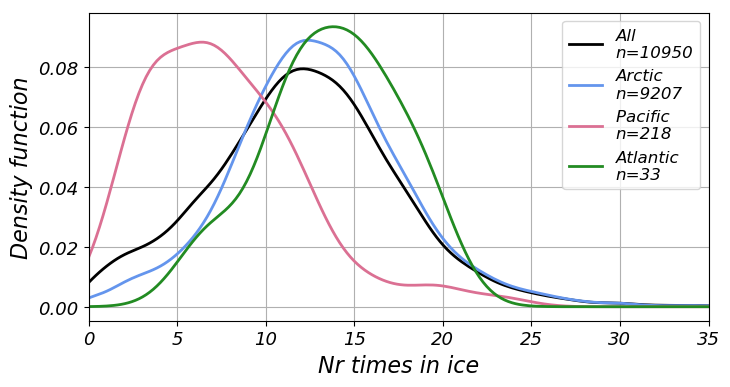

In [74]:
xx  = np.linspace(-1,100., 500)
pdf_all = make_pdf(nr_times_in_ice, xx)
pdf_arc = make_pdf(nr_arc, xx)
pdf_pac = make_pdf(nr_pac, xx)
pdf_atl = make_pdf(nr_atl, xx)

plt.plot(xx, pdf_all, label = "All \nn={}".format(len(nr_times_in_ice)), color = 'black')
plt.plot(xx, pdf_arc, label = "Arctic \nn={}".format(len(nr_arc)), color = 'cornflowerblue')
plt.plot(xx, pdf_pac, label = "Pacific \nn={}".format(len(nr_pac)), color='palevioletred')
plt.plot(xx, pdf_atl, label = "Atlantic\nn={}".format(len(nr_atl)), color = 'forestgreen')

plt.xlim([0,35])
plt.ylabel("Density function")
plt.xlabel("Nr times in ice")

plt.legend()

plt.savefig(home + "figures/trajectories/pdf_nr_into_ice_per_section.png", bbox_inches="tight", pad_inches=0.1)

# nr days in ice

In [117]:
nr_day_arc, nr_day_atl, nr_day_pac = count_per_section(be_ice, nr_days_in_ice, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac)

xx  = np.linspace(-1,2000., 2000*5)
pdf_all = make_pdf(nr_days_in_ice, xx)
pdf_arc = make_pdf(nr_day_arc, xx)
pdf_pac = make_pdf(nr_day_pac, xx)
pdf_atl = make_pdf(nr_day_atl, xx)


fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(xx, pdf_all, label = "All \nn={}".format(len(nr_times_in_ice)), color='b')
ax1.plot(xx, pdf_arc, label = "Arctic \nn={}".format(len(nr_arc)), color='cornflowerblue')
ax1.plot(xx, pdf_pac, label = "Pacific \nn={}".format(len(nr_pac)), color='palevioletred')
ax1.plot(xx, pdf_atl, label = "Atlantic\nn={}".format(len(nr_atl)), color='forestgreen')

ax1.set_xlim([0,2000])
ax1.set_ylabel("Density function")
ax1.set_xlabel("Nr days in ice")
ax1.legend(loc = 'center',  bbox_to_anchor=(0.5, 1.1), ncol= 4)

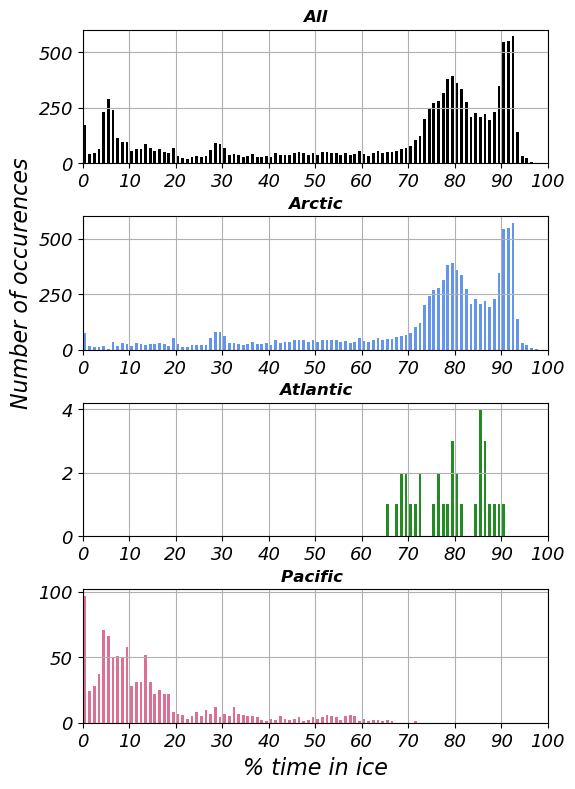

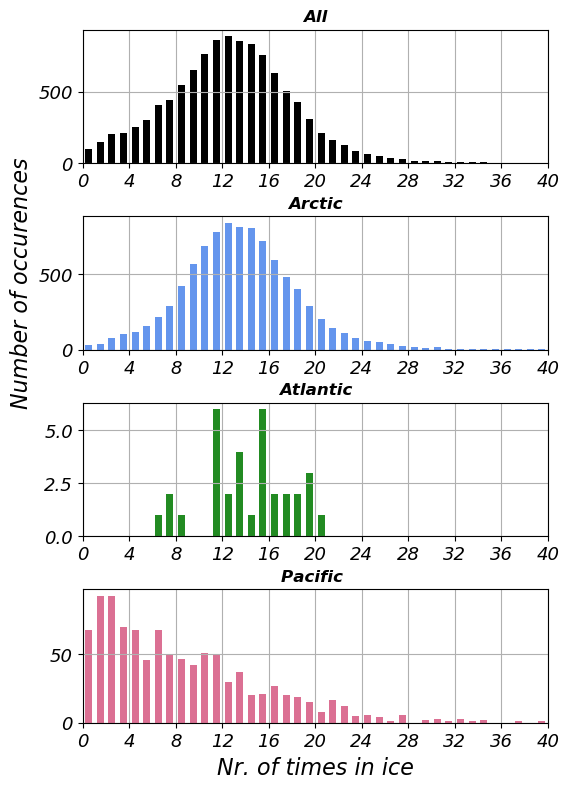

In [120]:
nr_days_percent = nr_days_in_ice/1700.*100

fig =make_histogram_four_no_sections(bins_histo=np.arange(0,101, 1), all_data=nr_days_percent, ds_locs=be_ice, label="% time in ice" )
plt.savefig(home + "figures/trajectories/hist_nr_days_ice_per_section.png", bbox_inches="tight", pad_inches=0.1)



fig =make_histogram_four_no_sections(bins_histo=np.arange(0,41, 1), all_data=nr_times_in_ice, ds_locs=be_ice, label="Nr. of times in ice" )
plt.savefig(home + "figures/trajectories/hist_nr_times_per_section.png", bbox_inches="tight", pad_inches=0.1)

# bering ocean vs ice

5830843.0
('icemean', 1340.9283)
('oceanmean', 1676.5293)


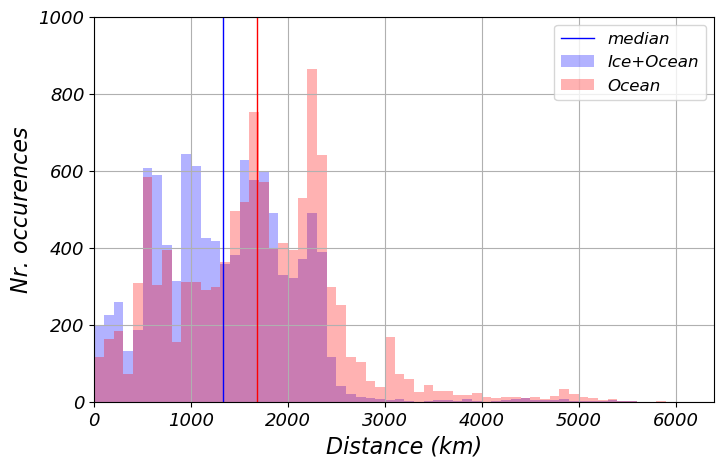

In [66]:
great_circle(-169., 66., -168.5, 66.)

ice_init  = be_ice.isel(obs=0)
ice_final = be_ice.isel(obs=-1)

ice_dist  = great_circle(ice_init.lon, ice_init.lat, ice_final.lon, ice_final.lat)

ocean_init  = be_ocean.isel(obs=0)
ocean_final = be_ocean.isel(obs=-1)

ocean_dist  = great_circle(ocean_init.lon, ocean_init.lat, ocean_final.lon, ocean_final.lat)
# print(ice_dist)
# print(ocean_dist)

print(np.nanmax([ice_dist, ocean_dist]))
bins_dist = np.arange(0, 6500, 100)

plt.figure(figsize = [8, 5])

plt.hist(ice_dist/1e3, bins=bins_dist, color='blue', alpha=0.3, label="Ice+Ocean")
plt.hist(ocean_dist/1e3, alpha=.3, bins=bins_dist, color= 'red', label = "Ocean")
plt.axvline(np.percentile(ice_dist[~np.isnan(ice_dist)]/1e3,50), color = 'blue', linewidth=1, label = 'median')
plt.axvline(np.percentile(ocean_dist[~np.isnan(ocean_dist)]/1e3, 50), color = 'red', linewidth=1)



print ("icemean", np.nanmean(ice_dist[~np.isnan(ice_nor_dist)]/1e3))
print ("oceanmean", np.nanmean(ocean_dist[~np.isnan(ocean_nor_dist)]/1e3))

plt.legend()
plt.xlabel("Distance (km)")
plt.ylabel("Nr. occurences")
plt.xlim([0, bins_dist[-1]])
plt.ylim([0,1000])
plt.savefig(home+"figures/pdf_distance_ice_ocean_bering.png")



# NORWAY

In [24]:
nor_ice = glob.glob(out_dir + "*norway*prob*time.nc")[0]
nor_ice = xr.open_dataset(nor_ice, decode_times=False)
nor_ice = nor_ice.isel(obs=np.arange(length))

nor_ocean = glob.glob(out_dir + "*norway*ocean*time.nc")[0]
nor_ocean = xr.open_dataset(nor_ocean, decode_times=False)
nor_ocean = nor_ocean.isel(obs=np.arange(length))

Text(0.5,0.98,'Norway')

<Figure size 800x400 with 0 Axes>

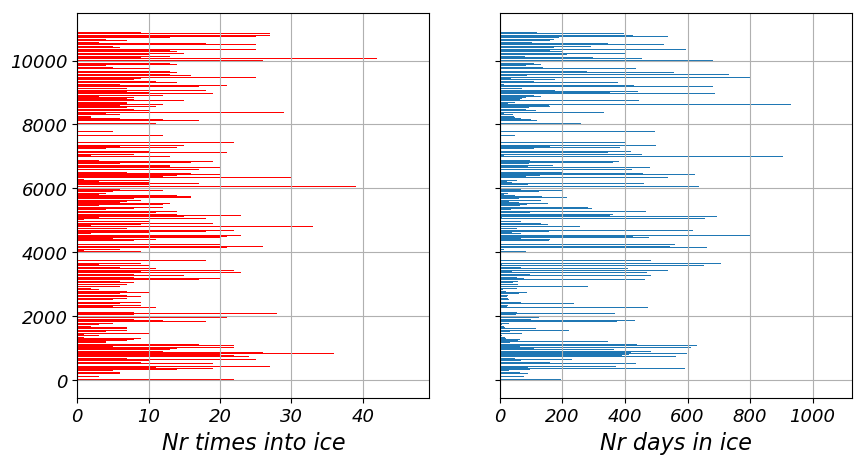

In [110]:
'''Find how often stuff goes in and out ice'''

in_ice_nor          = nor_ice.in_ice
nr_times_in_ice_nor = np.zeros(npart)
nr_days_in_ice_nor  = in_ice_nor.sum('obs')
# in_ice = in_ice.where(in_ice.traj<200,1)

for p in range(npart):
    in_out_nor             = (in_ice_nor.isel(traj=p)[1:]-in_ice_nor.isel(traj=p)[:-1])
    nr_times_in_ice_nor[p] = np.sum(in_out_nor[in_out_nor>0])+ in_ice_nor.isel(traj=p).isel(obs=0)

    
fig = plt.figure()
f , (ax2, ax3)= plt.subplots(1,2, sharey=True, figsize = (10,5))
# in_ice.plot(ax=ax1, add_colorbar= False)
ax2.barh(np.arange(npart),nr_times_in_ice_nor, label = "Nr times into ice", color = 'red')
ax3.barh(np.arange(npart),nr_days_in_ice_nor, label = "Nr days in ice")
ax2.set_xlabel("Nr times into ice")
ax3.set_xlabel("Nr days in ice")
fig.suptitle("Norway")

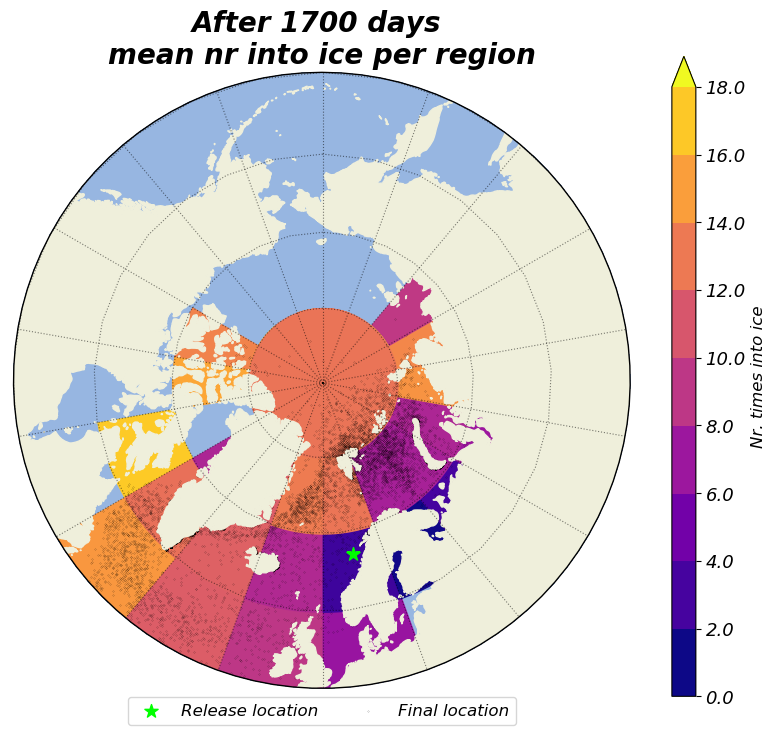

In [204]:
dlat, dlon = 10, 20 
bins_times   = np.arange(0,22., 2)

fig_kaart = plt.figure(figsize = [8,8])
ax        = fig_kaart.add_subplot(1,1, 1, projection=ccrs.NorthPolarStereo())
ax        = set_background(ax)


ax, means = fill_with_background(ax=ax, ds=nor_ice, histogram_data=nr_times_in_ice_nor, bounds=bins_times, dlat=dlat, dlon=dlon)


'''scatter points'''
a = ax.scatter(nor_ice.lon.isel(obs=0).isel(traj=0), nor_ice.lat.isel(obs=0).isel(traj=0), marker='*', transform=ccrs.PlateCarree(), color = "lime", s=1e2, label = "Release location", zorder = 10)
s = ax.scatter(nor_ice.lon.isel(obs=-1), nor_ice.lat.isel(obs=-1), transform=ccrs.PlateCarree(), color = "black", s=.01, label = "Final location")

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 0), ncol=2)
ax.set_title("After {} days \nmean nr into ice per region" .format(length))

plt.savefig("figures/trajectories/nr_times_in_ice_norway_10_a_day.png")

In [122]:
%%time

nr_ice_arc, nr_ice_atl, nr_ice_pac             = count_per_section(be_ice, be_ice.lon.isel(obs=-1).values, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=True)
nr_ice_arc_nor, nr_ice_atl_nor, nr_ice_pac_nor = count_per_section(nor_ice, nor_ice.lon.isel(obs=-1).values, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=True)


print("Ice\n====================")

print("Norway\n--------------------")
# print("all", len(nr_ice_times_in_ice_nor))
print("arc", len(nr_ice_arc_nor))
print("atl", len(nr_ice_atl_nor))
print("pac", len(nr_ice_pac_nor))

print("Bering\n--------------------")
# print("all", len(nr_ice_times_in_ice))
print("arc", len(nr_ice_arc))
print("atl", len(nr_ice_atl))
print("pac", len(nr_ice_pac))

nr_oc_arc, nr_oc_atl, nr_oc_pac             = count_per_section(be_ocean, be_ocean.lon.isel(obs=-1).values, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=True)
nr_oc_arc_nor, nr_oc_atl_nor, nr_oc_pac_nor = count_per_section(nor_ocean, nor_ocean.lon.isel(obs=-1).values, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac, non_nans=True)


print("\nOcean\n====================")

print("Norway\n--------------------")
# print("all", len(nr_oc_times_in_ice_nor))
print("arc", len(nr_oc_arc_nor))
print("atl", len(nr_oc_atl_nor))
print("pac", len(nr_oc_pac_nor))

print("Bering\n--------------------")
# print("all", len(nr_oc_times_in_ice))
print("arc", len(nr_oc_arc))
print("atl", len(nr_oc_atl))
print("pac", len(nr_oc_pac))

print("\nHigher than 80\n====================")

nor_ocean_80_arc, nor_ocean_80_atl , nor_ocean_80_pac = count_per_section(nor_ocean, nor_ocean.lon.isel(obs=-1).values, lon_arc, [80,90], lon_atl, lat_atl, lon_pac, [50,80], non_nans=True)
nor_ice_80_arc, nor_ice_80_atl ,  nor_ice_80_pac      = count_per_section(nor_ice, nor_ocean.lon.isel(obs=-1).values, lon_arc, [80,90], lon_atl, [50,80], lon_pac, [50,80], non_nans=True)

print("Ocean\n--------------------")
print('arc', len(nor_ocean_80_arc))
print('atl', len(nor_ocean_80_atl ))
print('pac', len(nor_ocean_80_pac))

print("Ice\n--------------------")
print('arc', len(nor_ice_80_arc))
print('atl', len(nor_ice_80_atl))
print('pac', len(nor_ice_80_pac))

Ice
Norway
--------------------
('arc', 7073)
('atl', 3877)
('pac', 0)
Bering
--------------------
('arc', 9207)
('atl', 33)
('pac', 1710)

Ocean
Norway
--------------------
('arc', 7897)
('atl', 3053)
('pac', 0)
Bering
--------------------
('arc', 10241)
('atl', 130)
('pac', 579)

Higher than 80
Ocean
--------------------
('arc', 2343)
('atl', 8206)
('pac', 401)
Ice
--------------------
('arc', 1144)
('atl', 9772)
('pac', 34)
CPU times: user 35 s, sys: 477 ms, total: 35.4 s
Wall time: 35.4 s


In [109]:
np.shape(nr_days_in_ice_nor)


(10950,)

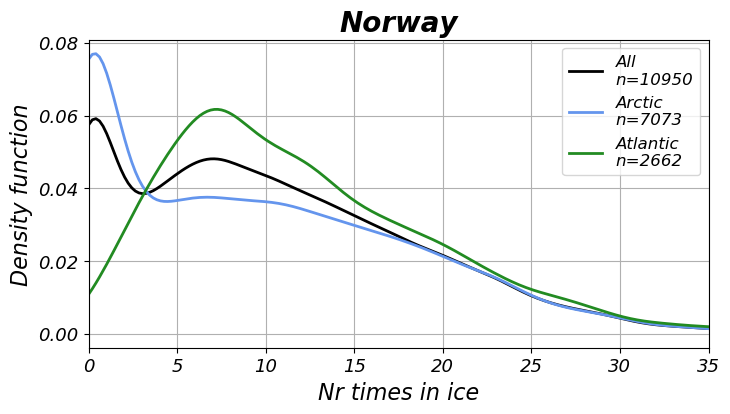

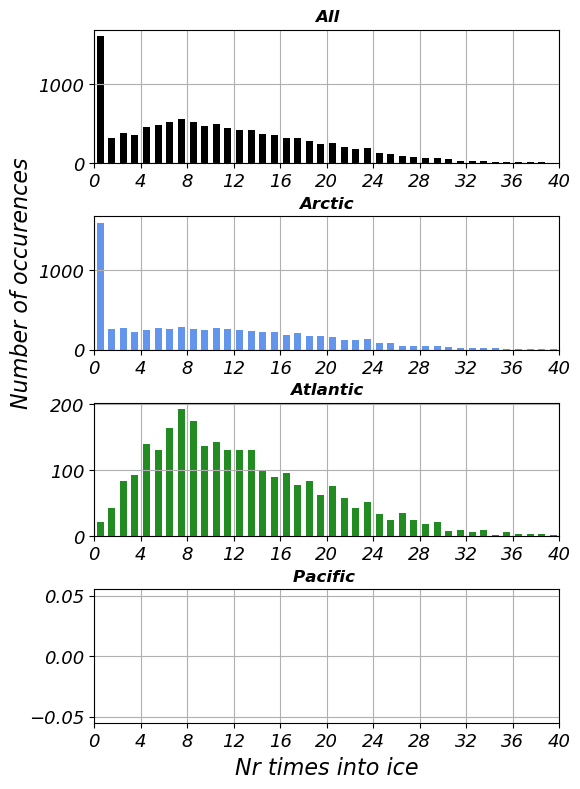

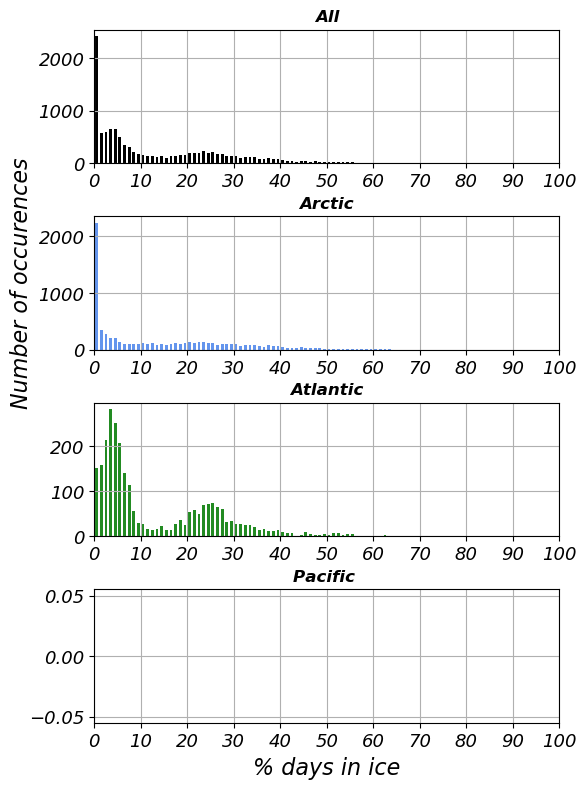

In [114]:

nr_arc_nor, nr_atl_nor, nr_pac_nor = count_per_section(nor_ice, nr_times_in_ice_nor, lon_arc, lat_arc, lon_atl, lat_atl, lon_pac, lat_pac)

xx  = np.linspace(-1,100., 500)
pdf_all = make_pdf(nr_times_in_ice_nor, xx)
pdf_arc = make_pdf(nr_arc_nor, xx)
# pdf_pac = make_pdf(nr_pac_nor, xx)
pdf_atl = make_pdf(nr_atl_nor, xx)

plt.plot(xx, pdf_all, label = "All \nn={}".format(len(nr_times_in_ice_nor)), color = 'black')
plt.plot(xx, pdf_arc, label = "Arctic \nn={}".format(len(nr_arc_nor)), color = 'cornflowerblue')
# plt.plot(xx, pdf_pac, label = "Pacific \nn={}".format(len(nr_pac_nor)), color='palevioletred')
plt.plot(xx, pdf_atl, label = "Atlantic\nn={}".format(len(nr_atl_nor)), color = 'forestgreen')

plt.xlim([0,35])
plt.ylabel("Density function")
plt.xlabel("Nr times in ice")
plt.title("Norway")
plt.legend()#loc = 'center',  bbox_to_anchor=(0.5, 1.1), ncol= 4)

# plt.savefig(home + "figures/trajectories/pdf_nr_into_ice_per_section_norway.png", bbox_inches="tight", pad_inches=0.1)

fig = make_histogram_four_no_sections(bins_histo=np.arange(-0,41,1), 
                                      all_data=nr_times_in_ice_nor, 
                                      ds_locs=nor_ice, label="Nr times into ice")
plt.savefig(home + "figures/trajectories/hist_nr_into_ice_per_section_norway.png", bbox_inches="tight", pad_inches=0.1)


# nr_days_in_ice_nor  /= 17.


fig = make_histogram_four_no_sections(bins_histo=np.arange(-0,101,1), 
                                      all_data=nr_days_in_ice_nor/17., 
                                      ds_locs=nor_ice, label="% days in ice")
plt.savefig(home + "figures/trajectories/hist_days_ice_per_section_norway.png", bbox_inches="tight", pad_inches=0.1)


4482308.5
('icemean', <xarray.DataArray ()>
array(1685.731, dtype=float32))
('oceanmean', <xarray.DataArray ()>
array(1803.2925, dtype=float32))


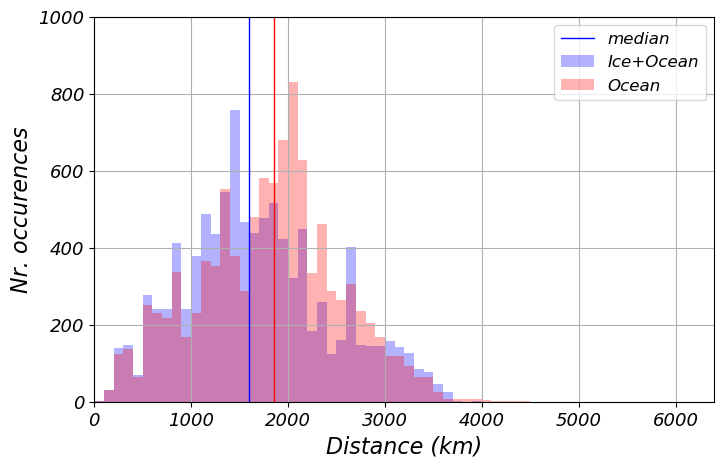

In [65]:

ice_nor_init  = nor_ice.isel(obs=0)
ice_nor_final = nor_ice.isel(obs=-1)

ice_nor_dist  = great_circle(ice_nor_init.lon, ice_nor_init.lat, ice_nor_final.lon, ice_nor_final.lat)

ocean_nor_init  = nor_ocean.isel(obs=0)
ocean_nor_final = nor_ocean.isel(obs=-1)

ocean_nor_dist  = great_circle(ocean_nor_init.lon, ocean_nor_init.lat, ocean_nor_final.lon, ocean_nor_final.lat)
# print(ice_nor_dist)
# print(ocean_nor_dist)

print(np.nanmax([ice_nor_dist, ocean_nor_dist]))
bins_dist = np.arange(0, 6500, 100)


plt.figure(figsize = [8, 5])
plt.hist(ice_nor_dist/1e3, bins=bins_dist, color='blue', alpha=0.3, label="Ice+Ocean")
plt.hist(ocean_nor_dist/1e3, alpha=.3, bins=bins_dist, color= 'red', label = "Ocean")
plt.axvline(np.percentile(ice_nor_dist[~np.isnan(ice_nor_dist)]/1e3,50), color = 'blue', linewidth=1, label = 'median')
plt.axvline(np.percentile(ocean_nor_dist[~np.isnan(ocean_nor_dist)]/1e3, 50), color = 'red', linewidth=1)


print ("icemean", np.mean(ice_nor_dist[~np.isnan(ice_nor_dist)]/1e3))
print ("oceanmean", np.mean(ocean_nor_dist[~np.isnan(ocean_nor_dist)]/1e3))

# xx = np.linspace(-100e3,6500e3, 1e5)
# pdf_ice_nor_dist  = make_pdf(ice_nor_dist[~np.isnan(ice_nor_dist)], xx)
# pdf_ocean_nor_dist = make_pdf(ocean_nor_dist[~np.isnan(ocean_nor_dist)],xx)

# plt.plot(xx,pdf_ice_nor_dist/np.max(pdf_ice_nor_dist)*500., color="darkblue", label="Ice+Ocean_nor kernel")
# plt.plot(xx,pdf_ocean_nor_dist/np.max(pdf_ocean_nor_dist)*500., color='darkgreen', label="Ocean_nor kernel")
plt.legend()
plt.xlabel("Distance (km)")
plt.ylabel("Nr. occurences")
plt.xlim([0, bins_dist[-1]])
plt.ylim([0,1000])
plt.savefig(home+"figures/pdf_distance_ice_ocean_norway.png", bbox_inches="tight", pad_inches=0.1)


# Bering release

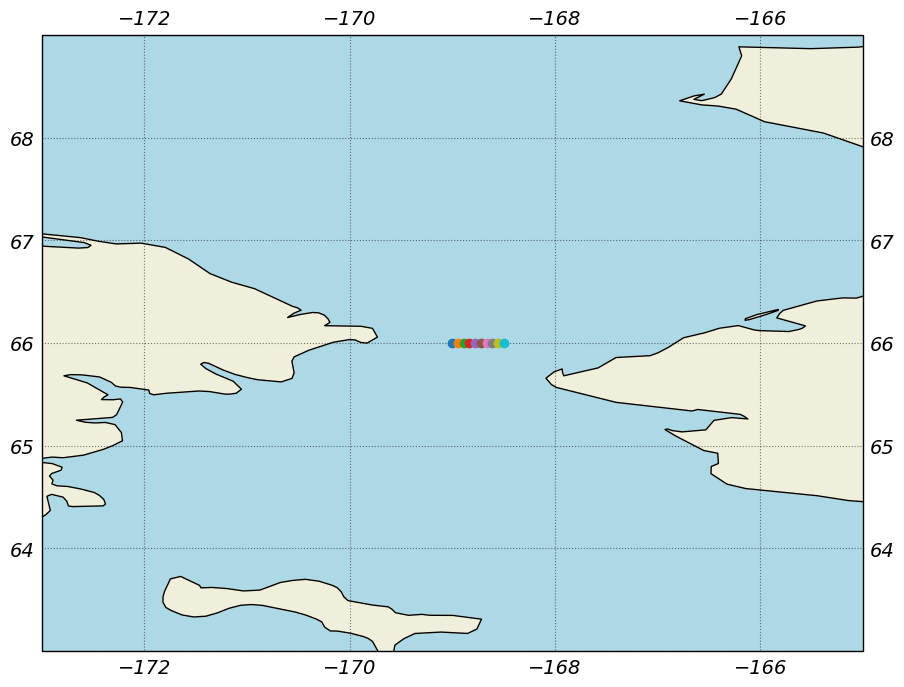

In [76]:
# bath_10m = cartopy.feature.NaturalEarthFeature('physical', 'bathymetry_all', '10m')

lon = np.linspace(-169,-168.5,10)
lat = np.linspace(66,66,10)

ymin, ymax = 63,69
xmin, xmax = -173,-165
dx, dy = 2, 1


plt.figure(figsize = [16,8])
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=65, central_longitude=-170, satellite_height=5e5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-165))
ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':', draw_labels=True)
ax.add_feature(plot_functions.ocean_50m)
ax.add_feature(plot_functions.land_50m)
# ax.add_feature(bath_10m)
ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())
ax.coastlines(resolution = '50m')
for i in range(10):
    ax.scatter(lon[i],lat[i], transform= ccrs.PlateCarree(),  zorder=10)
    
plt.savefig(home + "figures/release_location_10_per_day_bering.png")



# Norway release

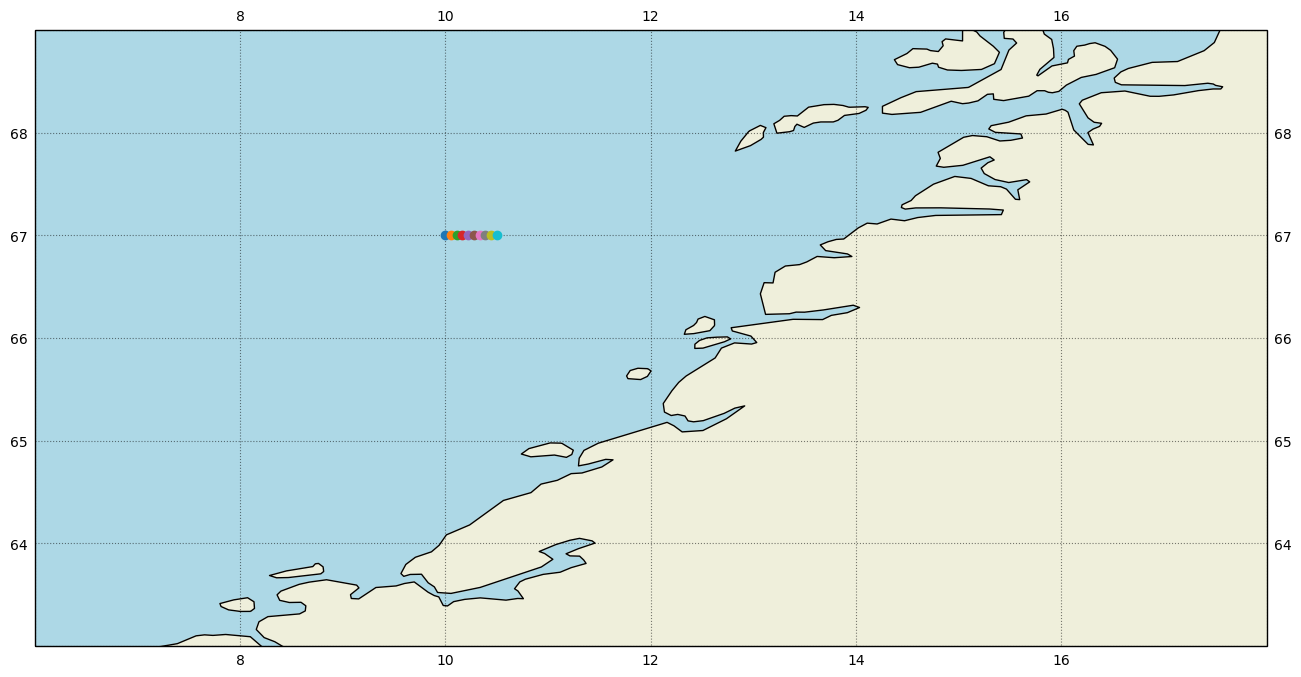

In [42]:
# bath_10m = cartopy.feature.NaturalEarthFeature('physical', 'bathymetry_all', '10m')

lon   = np.linspace(10,10.5,10)
lat   = np.repeat(67, 10)

ymin, ymax = 63,69
xmin, xmax = 6, 18
dx, dy = 2, 1


plt.figure(figsize = [16,8])
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean([xmin,xmax])))
ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':', draw_labels=True)
ax.add_feature(plot_functions.ocean_50m)
ax.add_feature(plot_functions.land_50m)

ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())
ax.coastlines(resolution = '50m')
for i in range(10):
    ax.scatter(lon[i],lat[i], transform= ccrs.PlateCarree(),  zorder=10)
    
# plt.savefig(home + "figures/release_location_10_per_day_norway.png")



# Trajectories

482


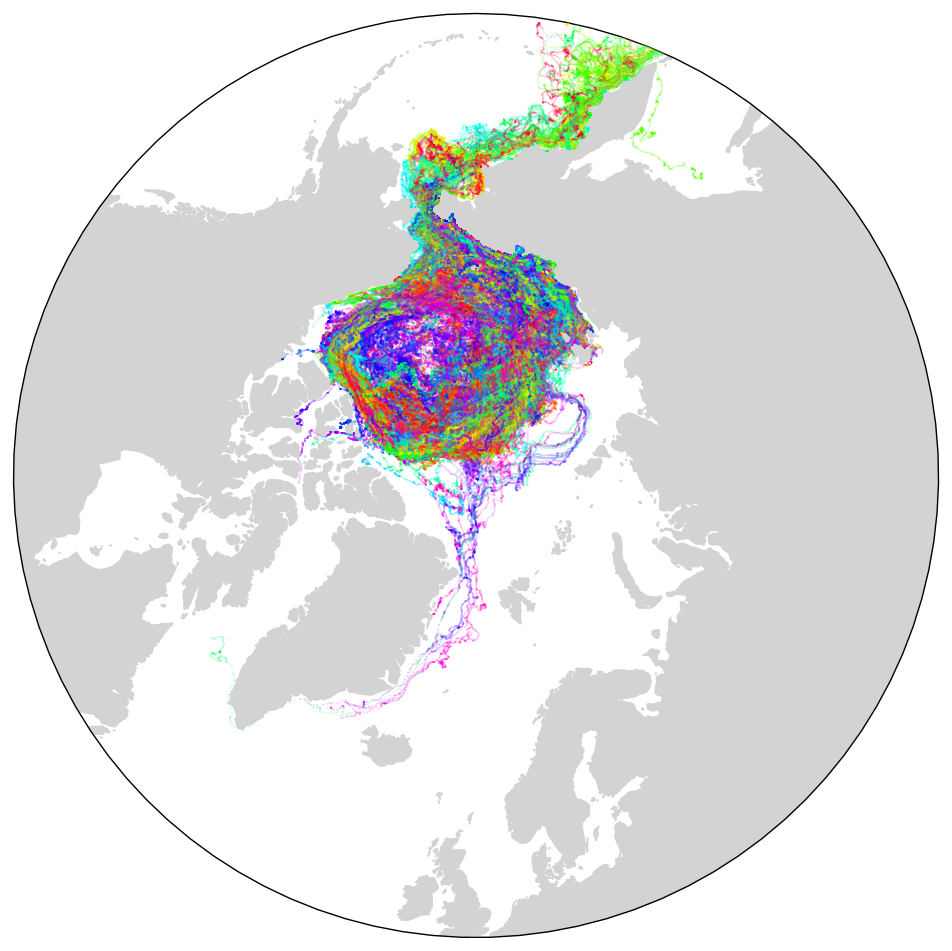

In [54]:
start = timer()
fig = plt.figure(figsize=[12,12])
ax  = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
dlat, dlon = 10, 20 
# ax  = set_background(ax)
ax.add_feature(plot_functions.land_50m, facecolor='lightgrey')
ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
plot_functions.set_circular_boundary(ax)
npart = np.size(be_ice.lon, 0)
p   = np.arange(0,npart,10)
t   = np.arange(1700)
for t in t:
    ax.scatter(be_ice.lon.isel(traj=p, obs=t), be_ice.lat.isel(traj=p, obs=t), c=be_ice.time.isel(traj=p, obs=0)%(86400*365), s=.01, cmap='hsv', transform=ccrs.Geodetic(), zorder=100)

plt.savefig("figures/traj_map_3.png")

print("{:.0f}".format(timer()-start))

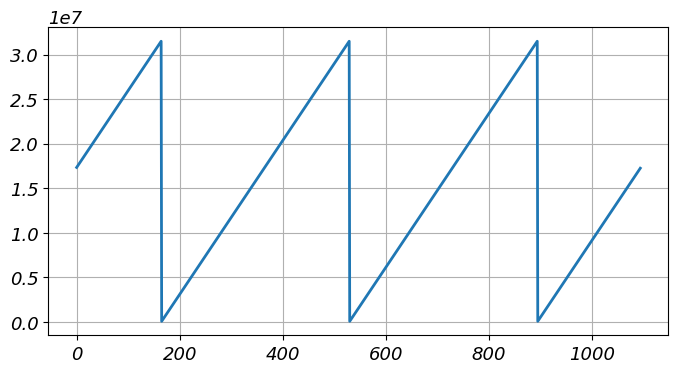

In [51]:
plt.plot(be_ice.time.isel(traj=p, obs=0)%(86400*365))

631 s


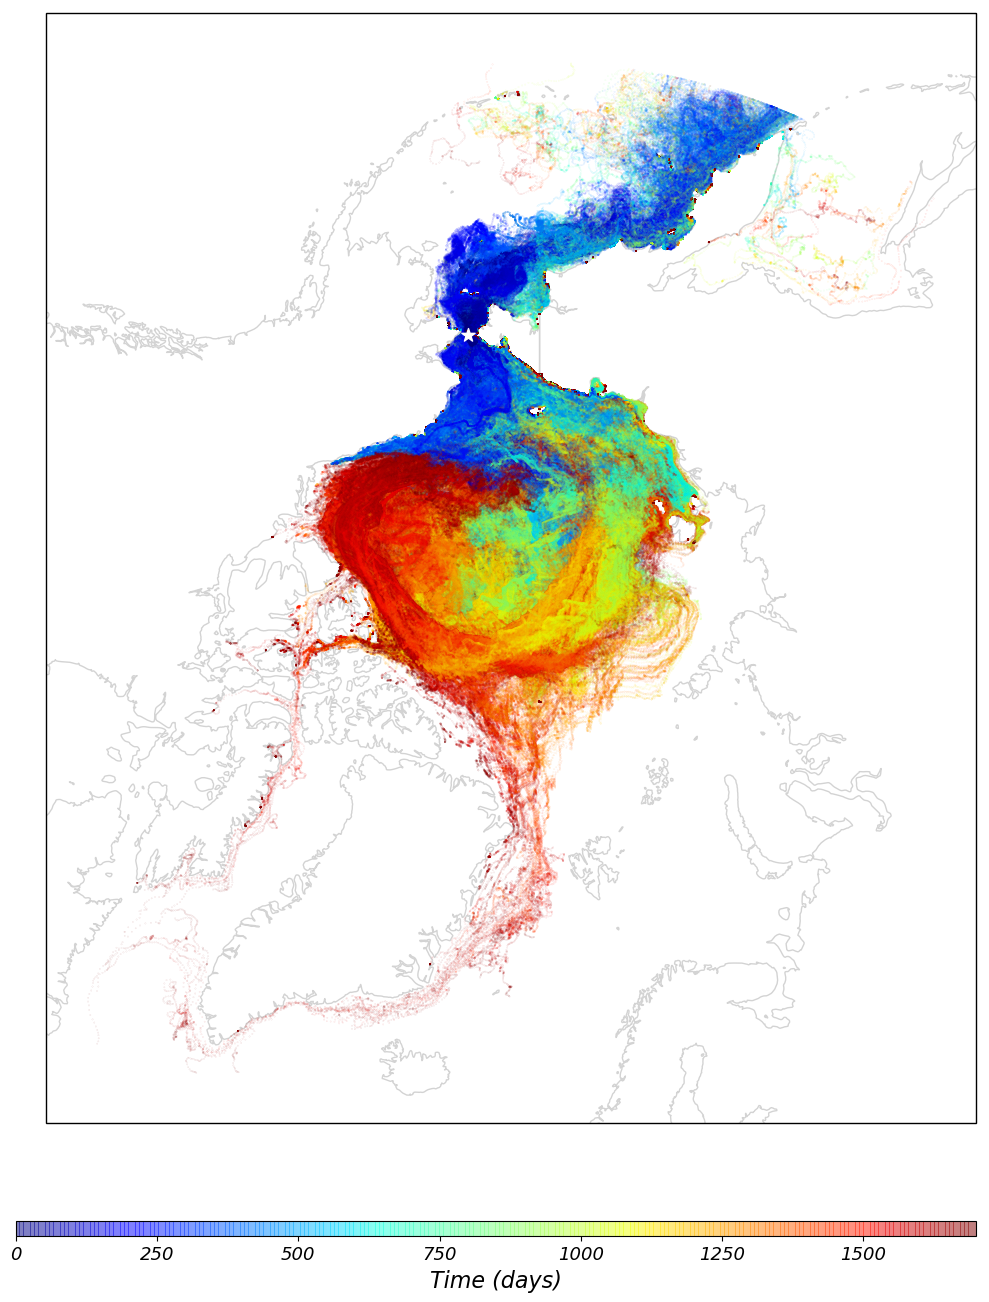

In [53]:
start = timer()
fig = plt.figure(figsize=[12,15])
ax  = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
dlat, dlon = 10, 20 
# ax.coastlines(alpha=.3)
# ax  = set_background(ax)
ax.add_feature(plot_functions.land_50m, edgecolor='lightgrey', facecolor='None')
# ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
# plot_functions.set_circular_boundary(ax)
npart = np.size(be_ice.lon, 0)
p   = np.arange(0,npart)
t   = np.arange(1700)

sc = ax.scatter(be_ice.lon.isel(traj=p, obs=t), be_ice.lat.isel(traj=p, obs=t), c=be_ice.time.isel(traj=p, obs=t)-be_ice.time.isel(traj=p, obs=0), s=.005, cmap='jet', transform=ccrs.Geodetic(), zorder=100, alpha=.5)


sc_start = ax.scatter(be_ice.lon.isel(traj=0, obs=0), be_ice.lat.isel(traj=0, obs=0), s=100, marker='*', transform=ccrs.Geodetic(), zorder=101, color = 'white')


ax_cbar = fig.add_axes([0.1, 0.05, 0.8, 0.01])

cb = fig.colorbar(sc, ax_cbar,  orientation='horizontal')
cb.set_label("Time (days)")
ticks = np.arange(0,1700,250)
cb.set_ticks(ticks*86400)
cb.set_ticklabels(ticks)



plt.savefig("figures/traj_map_10.png")

print("{:.0f} s".format(timer()-start))

# for gifs


In [89]:
be_things = glob.glob(out_dir + "*bering*prob*.nc")[0]
print be_things

/scratch/AnnekeV/output/single_particles/ten_per_day/bering-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_prob_dtdays_1_10_at_a_time.nc


In [94]:
nor_things = glob.glob(out_dir + "*norway*prob*.nc")[0]
print nor_things

/scratch/AnnekeV/output/single_particles/ten_per_day/norway-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_prob_dtdays_1_10_at_a_time.nc


In [ ]:
def shift_nans_10(fn):
    '''Shift the thing backward'''
    
    
    def shift_for_10(key, n=10, ndays=2801):
        '''
        Specifically for n releases at a time
        Default is n=10 particle release at a time
        For a simulation time of ndays=2800 days
        '''
        super_mat    = np.zeros([npart, npart//n+nobs])
        super_mat[:] = np.nan
        for i in range(npart):
            data                    = ds[key].values[i,:].copy()
            super_mat[i,i//n:i//n+nobs]   = data    
        return super_mat.copy()[:,:ndays]
    
    outputname = fn.split(".nc")[0]    
    ds         = xr.open_dataset(fn, decode_times=False)
    npart      = np.size(ds.time, 0)
    nobs       = np.size(ds.time, 1)
    
    for key, value in ds.iteritems():
        if key == "trajectory": 
            continue         
        data           = shift_for_10(key)
        ds[key].values = data

    ds.to_netcdf(outputname + "_shifted.nc")
    return ds

# ds = shift_nans_10(be_things)   
# ds = shift_nans_10(nor_things)   

In [210]:
import functions.distance
functions.distance.great_circle(-169., 66., -168.5, 66.)

22613.465710996028

In [ ]:
plot_functions.plot_extent()

In [6]:
kernel      = "AdvectionRK4_prob"
start_date  = "2014-02-01"
simdays     = 1000
year        = 2014
# output_name = advect_ice_single_particle.run_experiment(start_date = start_date, simdays = simdays, custom_kernel = kernel, outputdir = '/scratch/AnnekeV/output/single_particles/', year = year)



In [7]:
datetime.date(2014,2,1)+ datetime.timedelta(days=simdays)

datetime.date(2016, 10, 28)

In [8]:
datetime.date(2016,12,1) - datetime.date(2014,2,1)

datetime.timedelta(1034)

In [9]:
output_dir = "/scratch/AnnekeV/output/single_particles/"

In [35]:
filenames  = glob.glob(output_dir+ "*.nc")
for i in range(len(filenames)): print(filenames[i])

fn_back_oneday = glob.glob(output_dir+ "*backtrack*dtdays_1*")
print fn_back_oneday

/scratch/AnnekeV/output/single_particles/backtrack-04-26_npart_10_start_2014-02-01_simdays_1000_kernel_AdvectionRK4_prob_dtdays_5.nc
/scratch/AnnekeV/output/single_particles/04-26_npart_5_start_2013-02-01_simdays_1400_kernel_AdvectionRK4_prob_dtdays_1.nc
/scratch/AnnekeV/output/single_particles/backtrack-04-26_npart_10_start_2016-12-01_simdays_1400_kernel_AdvectionRK4_prob_dtdays_1.nc
/scratch/AnnekeV/output/single_particles/04-26_npart_5_start_2014-02-01_simdays_1000_kernel_AdvectionRK4_prob_dtdays_1.nc
/scratch/AnnekeV/output/single_particles/04-26_npart_5_start_2014-02-01_simdays_1000_kernel_AdvectionRK4_prob.nc
['/scratch/AnnekeV/output/single_particles/backtrack-04-26_npart_10_start_2016-12-01_simdays_1400_kernel_AdvectionRK4_prob_dtdays_1.nc']


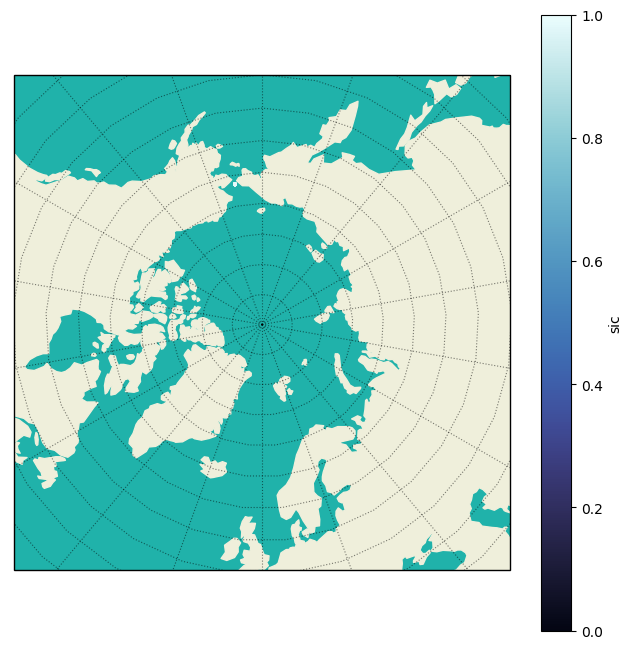

In [149]:
# Initialize figure 
color_var = 'sic'
label_name = "sic"
fig, ax = plot_functions.set_fig()
scat = ax.scatter(ds.lon.values[:,0], ds.lat.values[:,0], s =3, c=ds[color_var].values[:,0], transform = ccrs.PlateCarree() , cmap = cmocean.cm.ice)
cbar = plt.colorbar(scat)
cbar.set_label(label_name)

Text(0,0.5,'Very custom cbar [-]')

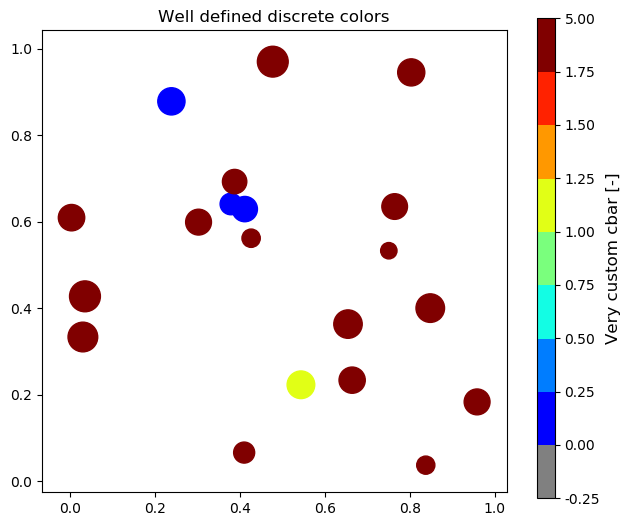

In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

x = np.random.rand(20)  # define the data
y = np.random.rand(20)  # define the data
tag = np.random.randint(0, 20, 20)
tag[10:12] = 0  # make sure there are some 0 values to show up as grey

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap_custom = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(-.25, 2.1, .25,)
bounds[-1] = 5
norm = mpl.colors.BoundaryNorm(bounds, cmap_custom.N)

# make the scatter
scat = ax.scatter(x, y, c=tag, s=np.random.randint(100, 500, 20),
                  cmap=cmap_custom, norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap_custom, norm=norm,
    spacing='uniform', ticks=bounds, boundaries=bounds, format='%.2f')

ax.set_title('Well defined discrete colors')
ax2.set_ylabel('Very custom cbar [-]', size=12)

In [153]:
ds = xr.open_dataset(fn_back_oneday[0], decode_times=False)


NameError: name 'fn_back_oneday' is not defined

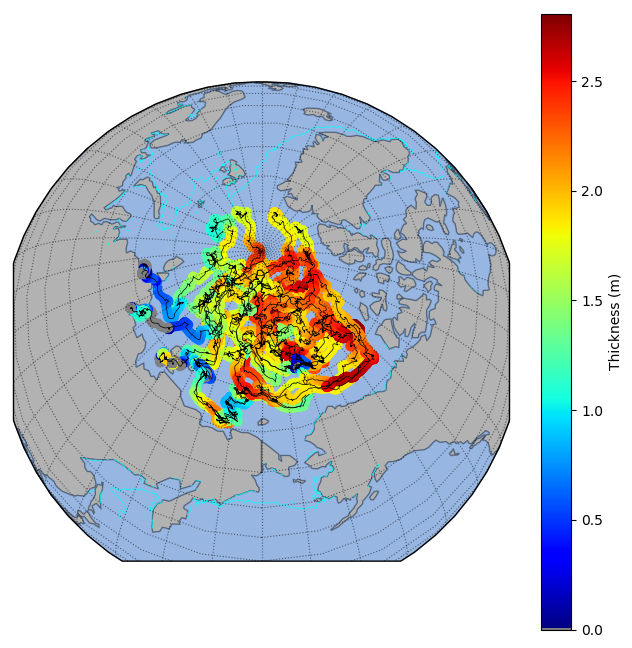

In [45]:
ymin, ymax = 50,80
xmin, xmax = -180,180
dx, dy = 10, 5

npart = np.size(ds.lat.values,0)

plt.figure(figsize = [8,8])
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=80, central_longitude=-180, satellite_height=4e6))
ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND,facecolor = (0,0,0,.3))
# ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())


for p in range(npart):
    ax.plot(ds.lon.where(ds.lon>0, ds.lon+360).isel(traj=p), ds.lat.isel(traj=p), 
            transform = ccrs.PlateCarree(), color = "black", linewidth = .5)
    
scat = ax.scatter(ds.lon.where(ds.lon>0, ds.lon+360), ds.lat, 
            transform = ccrs.PlateCarree(), c = ds.sit, cmap = cmap_custom)
        
    

sic = plot_functions.plot_extent_contour(datetime.datetime(2014,3,1), ax)
ax.set_title("")

cbar = plt.colorbar(scat)
cbar.set_label("Thickness (m)")


In [46]:
# start_date = datetime.datetime(2014,2,1)
# end_date   = start_date + datetime.timedelta(days = 1001)

# time_array = np.arange(start_date, end_date, datetime.timedelta(days=1))

# plt.figure()

# for i in range(5):
#     plt.plot(time_array, ds.sit.isel(traj=i))
    
# plt.ylabel("Sea ice thickness (m)")
# plt.xticks(rotation= 45)
    

In [47]:
start_date = datetime.datetime(2013,2,1)
end_date   = start_date + datetime.timedelta(days = 1400)
print end_date

np.zeros(2)
print( np.arange(1,8))


2016-12-02 00:00:00
[1 2 3 4 5 6 7]


Text(0.5,1,'')

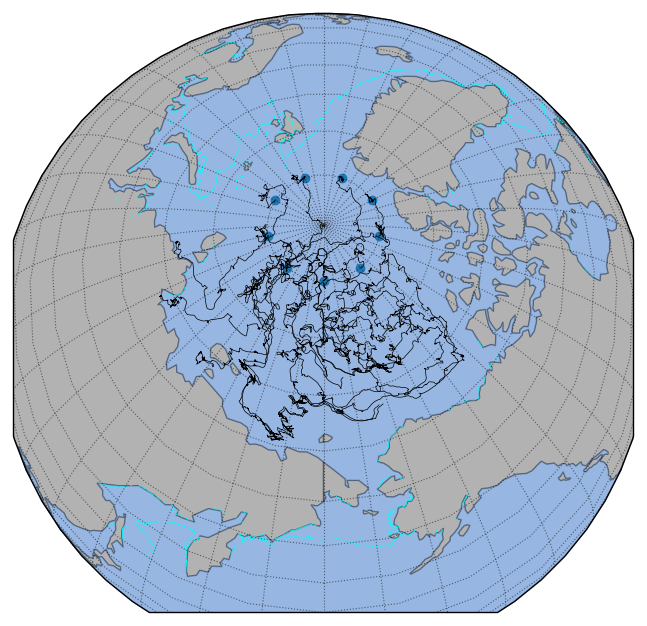

In [48]:
# backtrackfile = glob.glob(output_dir+ "back*.nc")[0]
# ds = xr.open_dataset(backtrackfile, decode_times=False)


ymin, ymax = 50,80
xmin, xmax = -180,180
dx, dy = 10, 5

npart = np.size(ds.lat.values,0)

plt.figure(figsize = [8,8])
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=80, central_longitude=-180, satellite_height=4e6))
ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND,facecolor = (0,0,0,.3))
# ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())


for p in range(npart):
    ax.plot(ds.lon.where(ds.lon>0, ds.lon+360).isel(traj=p), ds.lat.isel(traj=p), 
            transform = ccrs.PlateCarree(), color = "black", linewidth = .5)
    
scat = ax.scatter(ds.lon.where(ds.lon>0, ds.lon+360).isel(obs=0), ds.lat.isel(obs=0), 
            transform = ccrs.PlateCarree(), 
#                   c = ds.sit,  cmap = cmap_custom
                 )
        
    

sic = plot_functions.plot_extent_contour(datetime.datetime(2014,3,1), ax)
ax.set_title("")

# cbar = plt.colorbar(scat)
# cbar.set_label("Thickness (m)")



(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))
(array(85.115814, dtype=float32), array(-177.62181, dtype=float32))


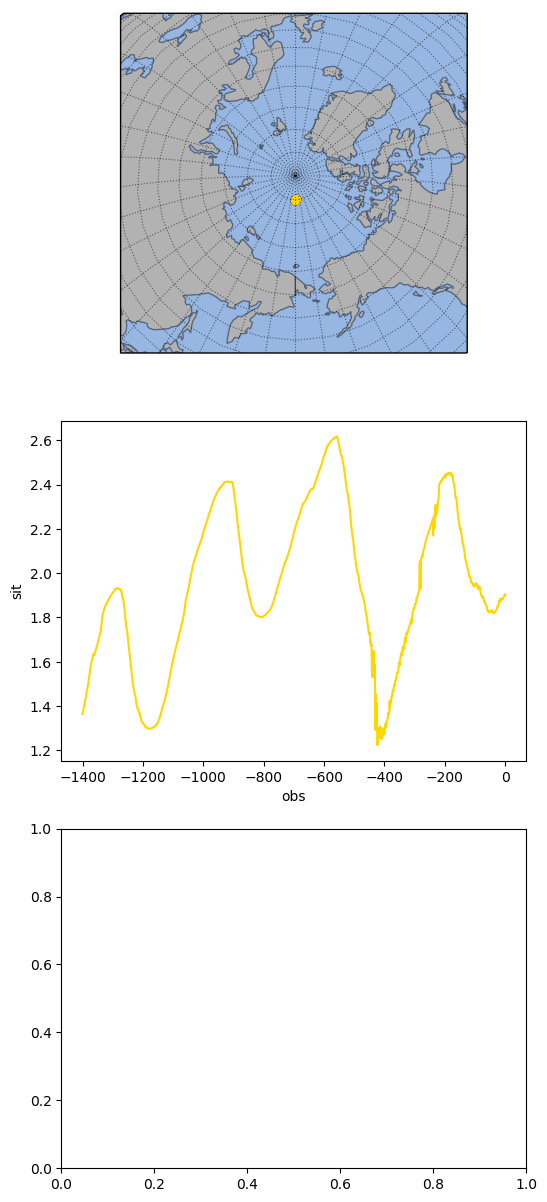

In [49]:
cmaplist = ["gold", "blue" ,"cyan", "red", "orange" ,"green", "purple", "black", "grey", "gold", "blue" ,"cyan", "red", "orange" ,"green", "purple", "black", "grey", "lavenderblue"]

npart  = np.size(ds.lat.values,0)
nplots = 3


fig = plt.figure(figsize=[6,nplots*5])
ax1 = fig.add_subplot(nplots, 1, 1, projection=ccrs.NearsidePerspective(central_latitude=80, central_longitude=-180, satellite_height=4e8))
ax1.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND,facecolor = (0,0,0,.3))
ax1.set_extent([-360,20,50,90],  ccrs.PlateCarree())
# ax1.set_global()

npart = 1


sic = plot_functions.plot_extent_contour(datetime.datetime(2014,3,1), ax)
ax.set_title("")

for j in range(npart):
    sits = []    
    days = []
    testpart = ds.isel(traj=j)
    ref_day  = 0

    for i in range(10):
        days.append(ref_day)

        ref_sit = testpart.sit.isel(obs=ref_day)
        sits.append(ref_sit)

        all_sits = testpart.sit.values

        day = ref_day +1
        while ref_sit < all_sits[day]:
            day += 1

        print (testpart.lat.isel(obs= day).values, testpart.lon.isel(obs=day).values)

        scat = ax1.scatter(testpart.lon.isel(obs= ref_day).values, testpart.lat.isel(obs=0).values, transform = ccrs.PlateCarree(), color = cmaplist[i])
        scat = ax1.scatter(testpart.lon.isel(obs= day).values, testpart.lat.isel(obs=day).values, transform = ccrs.PlateCarree(),   color = cmaplist[i] )
    
        
        
#         ref_day += 100
        


ax2 = fig.add_subplot(nplots,1,2)
for j in range(npart):
    testpart = ds.isel(traj=j)        
#     testpart.sit.plot(color = cmaplist[j], ax = ax2)
    ax2.plot(-testpart.obs[::-1], testpart.sit[::-1], color= cmaplist[j])
#     ax2.scatter(days,sits[::-1])
    
    ax2.set_xlabel(testpart.obs.name)
    ax2.set_ylabel(testpart.sit.name)

    
    
ax3 = fig.add_subplot(nplots,1,3)




# Central difference scheme

$\frac{dh}{dt}$


In [187]:

def central_difference(data):
    '''
    Calculates the central difference in case of sea ice thickness
    Input dataset xarray with .sit and .obs
    Returns sea ice growth in array form
    '''
    sit_array  = data.sit
    obs_array  = data.obs
    sit_growth = np.zeros(len(sit_array.values))


    for i in range(1,len(sit_array.values)-1):
        dt            = obs_array[i+1]-obs_array[i-1]
        dh            = sit_array[i+1]-sit_array[i-1]
        sit_growth[i] = dh/dt

    sit_growth[0]  =  (sit_array[1]-sit_array[0])   /( obs_array[1]-obs_array[0])
    sit_growth[-1] =  (sit_array[-1]-sit_array[-2]) /( obs_array[-1]-obs_array[-2])
    
    return sit_growth

def roll_average(data, windowsize):
    backupdata = data.copy()[:]
    data       = data.rolling(obs=windowsize, center=True, min_periods=1).mean()
    return data.where(~np.isnan(data), backupdata)



def get_sign_derivative(data):
    data['sit'] = roll_average(data.sit,50)
    sig         = central_difference(smooth_sit)    # sig
    return sig/abs(sig)






/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


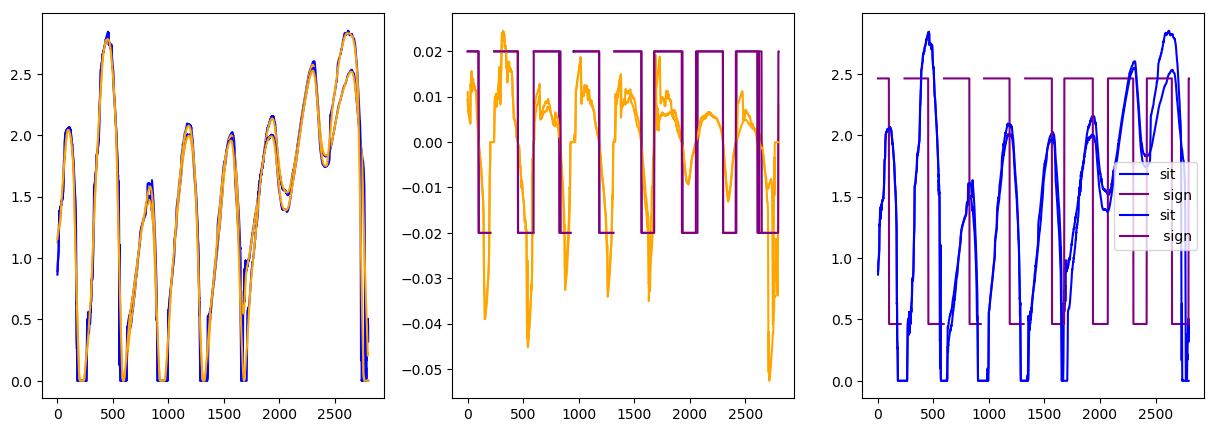

In [188]:
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for j in range(2):
    testpart = ds.isel(traj=j)


    smooth_sit = testpart.copy()
    smooth_sit['sit'] = roll_average(smooth_sit.sit,50)
    ax1.plot(testpart.sit, color = 'blue', label = "sit")
    ax1.plot(smooth_sit.sit, color = 'orange', label = "sit smooth")



    sig = central_difference(smooth_sit)
    # plt.plot(central_difference(testpart), color = 'blue')
    ax2.plot(sig, color = 'orange', label = "sig")
    
    ax2.plot(sig/abs(sig)/50, color = 'purple', label = "sig_sign")


    ax3.plot(testpart.sit, color = 'blue', label = "sit")
    ax3.plot(sig/abs(sig)+ np.mean(testpart.sit.values), color = 'purple', label = " sign")
plt.legend()

/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


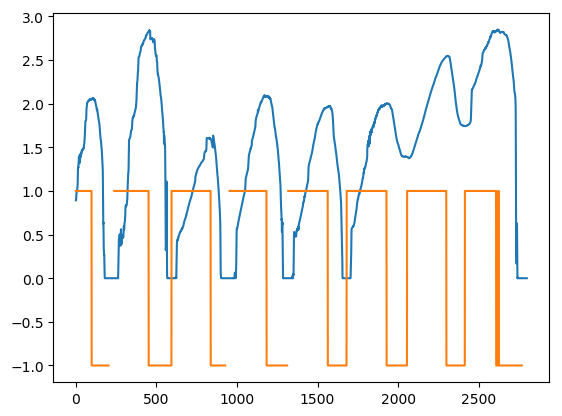

In [189]:
plt.plot(testpart.sit)
plt.plot(get_sign_derivative(testpart))

In [190]:
melt_or_freeze = get_sign_derivative(testpart) # if larger than 0, then melt (since backtracking)
sitsit         = testpart.sit.values
latlat         = testpart.lat.values
lonlon         = testpart.lon.values

/home/students/6252699/miniconda2/envs/parcels2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


In [191]:
ndays = len(testpart.obs)
empty_matrix= np.ones([ndays,8])*-999
counter = 0

print("i\tj\tsit_i\tsit_j\tlon_i\tlat_i\tlon_j\tlat_j")
print("===============================================================")
for i in range(ndays):
    
    if melt_or_freeze[i] ==1.:
        j = i+1
        while j < ndays:
            if sitsit[j]<sitsit[i] and melt_or_freeze[j] == -1.:
                print("{}\t{}\t{:.2f}\t{:.2f}\t{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}".format(i,j,sitsit[i],sitsit[j],lonlon[i],latlat[i],lonlon[j],latlat[j]))
                empty_matrix[counter, :] = [i,j,sitsit[i],sitsit[j],lonlon[i],latlat[i],lonlon[j],latlat[j]]
                counter+=1
                
                j+=1e9
            j+=1

i	j	sit_i	sit_j	lon_i	lat_i	lon_j	lat_j
0	159	1.23	1.20	-169.0	66.5	178.3	70.8
1	158	1.24	1.23	-169.0	66.5	178.5	70.7
2	158	1.24	1.23	-169.0	66.5	178.5	70.7
3	158	1.24	1.23	-169.1	66.6	178.5	70.7
4	158	1.25	1.23	-169.1	66.6	178.5	70.7
5	158	1.25	1.23	-169.1	66.5	178.5	70.7
6	158	1.25	1.23	-169.1	66.5	178.5	70.7
7	158	1.26	1.23	-169.0	66.4	178.5	70.7
8	158	1.26	1.23	-169.0	66.4	178.5	70.7
9	157	1.27	1.26	-169.0	66.4	178.9	70.7
10	157	1.27	1.26	-169.1	66.4	178.9	70.7
11	157	1.27	1.26	-169.1	66.5	178.9	70.7
12	157	1.28	1.26	-169.2	66.5	178.9	70.7
13	157	1.28	1.26	-169.2	66.5	178.9	70.7
14	157	1.29	1.26	-169.1	66.5	178.9	70.7
15	156	1.29	1.29	-169.0	66.4	179.4	70.6
16	156	1.30	1.29	-168.9	66.4	179.4	70.6
17	156	1.30	1.29	-169.0	66.4	179.4	70.6
18	156	1.31	1.29	-169.1	66.5	179.4	70.6
19	156	1.31	1.29	-169.1	66.6	179.4	70.6
20	156	1.32	1.29	-169.2	66.7	179.4	70.6
21	155	1.33	1.32	-169.4	67.1	179.9	70.6
22	155	1.33	1.32	-169.3	67.5	179.9	70.6
23	155	1.34	1.32	-169.2	67.7	179.9	70.6
24	155	1.3

In [192]:
empty_matrix[empty_matrix==-999.] = np.nan

In [193]:
empty_matrix

array([[  0.        , 159.        ,   1.23498368, ...,  66.5       ,
        178.28746033,  70.75248718],
       [  1.        , 158.        ,   1.23752654, ...,  66.49736023,
        178.52432251,  70.70497894],
       [  2.        , 158.        ,   1.24034858, ...,  66.51277924,
        178.52432251,  70.70497894],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [194]:
empty_matrix[:,2]//.1

array([12., 12., 12., ..., nan, nan, nan])

In [195]:
import pandas as pd

In [196]:
ds2 = pd.DataFrame(data=empty_matrix, columns=['i', 'j', 'sit_i', 'sit_j', 'lon_i', 'lat_i', 'lon_j', 'lat_j'])

ds2 = ds.dropna()

TypeError: dropna() takes at least 2 arguments (1 given)

In [ ]:

numbers = [1, 1, 1, 3, 3, 2, 2, 2, 1, 1] 
import itertools 
for (key,group) in itertools.groupby(numbers): 
    print (key,list(group)) 

    

In [ ]:
sit_i_discrete = empty_matrix[:,2]//.1
layer_i = sit_i_discrete[0]

i       = 0
all_layers = []

nr_pairs = np.argwhere(np.isnan(sit_i_discrete))[0][0]

print("{}\t{}\n=================".format("index","layer_id"))

while i < nr_pairs:
    layer   = []
    print("{}\t{}".format(i, int(layer_i)))
    while layer_i == sit_i_discrete[i]:
        layer.append(empty_matrix[i,:])
        i+=1
    all_layers.append(layer)
    layer_i = sit_i_discrete[i]


np.shape(all_layers[2])
    

In [ ]:
np.shape(all_layers)
np.array(all_layers[0][:])[:,4]

In [ ]:
ymin, ymax = 50,80
xmin, xmax = -180,180
dx, dy = 10, 5

for i in range(len(all_layers)):


    plt.figure(figsize = [5,5])
    ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=90, central_longitude=-180, satellite_height=4e6))
    ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':')
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND,facecolor = (0,0,0,.3))
    # ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())

    spec_layer = np.array(all_layers[i])
    scat = ax.scatter(spec_layer[:,4], spec_layer[:,5], transform=ccrs.PlateCarree(), color='gold')
    scat = ax.scatter(spec_layer[:,6], spec_layer[:,7], transform=ccrs.PlateCarree(), color='orange')


    sic = plot_functions.plot_extent_contour(datetime.datetime(2014,3,1), ax)
    ax.set_title("")
    plt.show()

# cbar = plt.colorbar(scat)
# cbar.set_label("Thickness (m)")


# For a fixed point

In [ ]:
core_thickness = testpart.sit[0]
print(core_thickness)

core_layers = np.arange(0,core_thickness, 0.01)
loncore,latcore = testpart.lon.values[0], testpart.lat.values[0]
nr_pos_pairs    = len(core_layers)


ndays = len(testpart.obs)
# ndays = 20
empty_matrix_for_core = np.ones([nr_pos_pairs,8])*-999
counter = 0


'''FIND PAIRS'''
print("i\tj\tsit_i\tsit_j\tlon_i\tlat_i\tlon_j\tlat_j")
print("===============================================================")
for i in range(nr_pos_pairs):
    
    if melt_or_freeze[i] ==1.:
        j = 0
        while j < ndays:
            if sitsit[j]<core_layers[i] and melt_or_freeze[j] == -1.:
                print("{}\t{}\t{:.2f}\t{:.2f}\t{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}".format(i,j,core_layers[i],sitsit[j],loncore, latcore,lonlon[j],latlat[j]))
                empty_matrix_for_core[counter, :] = [i,j,core_layers[i],sitsit[j],loncore,latcore,lonlon[j],latlat[j]]
                counter+=1
                
                j+=1e9
            j+=1
            
empty_matrix_for_core[empty_matrix_for_core==-999.] = np.nan

'''DATAFRAME'''
ds_core = pd.DataFrame(data=empty_matrix_for_core, columns=['i', 'j', 'sit_i', 'sit_j', 'lon_i', 'lat_i', 'lon_j', 'lat_j'])
ds_core = ds_core.dropna()


'''GROUP IN LAYERS OF 10 CM'''
sit_i_discrete_core = empty_matrix_for_core[:,2]//.1   # 0.1 m gropus
layer_i = sit_i_discrete_core[0]
nr_pairs = np.argwhere(np.isnan(sit_i_discrete_core))[0][0]



print nr_pairs
i       = 0
all_layers_core = []
print("\n{}\t{}\n=================".format("index","layer_id"))

while i < range(nr_pairs):
    layer   = []
    print("{}\t{}".format(i, int(layer_i)))
    while layer_i == sit_i_discrete_core[i]:
        layer.append(empty_matrix_for_core[i,:])
        i+=1
    all_layers_core.append(layer)
    if i == nr_pairs: break
    layer_i = sit_i_discrete_core[i]


np.shape(all_layers_core)
    

In [ ]:
ymin, ymax = 50,80
xmin, xmax = -180,180
dx, dy = 10, 5


plt.figure(figsize = [5,5])
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=90, central_longitude=-180, satellite_height=4e6))
ax.gridlines(xlocs = np.arange(-180,185,dx), ylocs = np.arange(0,95,dy), color='black', alpha=0.5, linestyle=':')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND,facecolor = (0,0,0,.3))
# ax.set_extent([xmin,xmax,ymin,ymax],  ccrs.PlateCarree())

stepsize = len(cmaplist)//len(all_layers_core)
scat = ax.scatter(spec_layer[:,4], spec_layer[:,5], transform=ccrs.PlateCarree(), color='black', label = "core_loc")

for i in range(len(all_layers_core)):
    spec_layer  = np.array(all_layers_core[i])
    layer_label = "{}-{}".format(spec_layer[0,2]//.1/10., spec_layer[0,2]//.1/10.+.1)
    scat = ax.scatter(spec_layer[:,6], spec_layer[:,7], transform=ccrs.PlateCarree(), color=cmaplist[stepsize*i], label = layer_label)


sic = plot_functions.plot_extent_contour(datetime.datetime(2014,3,1), ax)
ax.set_title("")
plt.legend(bbox_to_anchor=(0.5, 1.05))
plt.show()


In [ ]:
import functions.distance as dist
def distance_parameters(lons1, lats1, lons2, lats2):
    distances  = dist.great_circle(lons1, lats1, lons2, lats2)
    dist_mean  = np.mean(distances)
    dist_max   = np.max(distances)
    dist_min   = np.min(distances)
    
    print("Mean {:.1f} km \n Max {:.1f} km \n Min {:.1f} km".format(dist_mean/1000., dist_max/1000., dist_min/1000.))
    return dist_mean, dist_max, dist_min

    

In [71]:
layer_0 = np.array(all_layers[0])

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

14.0
Mean 579.1 km 
 Max 631.9 km 
 Min 520.3 km
15.0
Mean 484.7 km 
 Max 517.3 km 
 Min 453.0 km
15.0
Mean 450.5 km 
 Max 471.8 km 
 Min 433.6 km
17.0
Mean 361.4 km 
 Max 413.0 km 
 Min 332.8 km
18.0
Mean 737.9 km 
 Max 955.4 km 
 Min 369.5 km
18.0
Mean 897.5 km 
 Max 914.2 km 
 Min 869.2 km


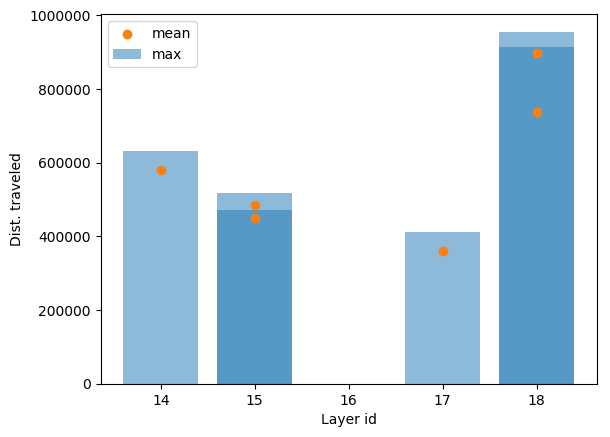

In [193]:
label_id, means, maxes = np.zeros(len(all_layers_core)), np.zeros( len(all_layers_core)), np.zeros( len(all_layers_core))

for i in range(len(all_layers_core)):
    spec_layer = np.array(all_layers_core[i])
    label_id[i] =spec_layer[0,3]//.1
    print label_id[i]
    means[i], maxes[i], _ = distance_parameters(spec_layer[:,4], spec_layer[:,5], spec_layer[:,6], spec_layer[:,7])
plt.bar(label_id, maxes, alpha = .5, label = "max")
plt.scatter(label_id, means, zorder = 10, label = "mean")
plt.xlabel("Layer id")
plt.ylabel("Dist. traveled")
plt.legend()

# ===============================================================
# Kladblok
# ===============================================================

In [5]:
ten_per_day = sorted(glob.glob("/scratch/AnnekeV/output/single_particles/ten_per_day/*"))

In [6]:
ten_per_day

['/scratch/AnnekeV/output/single_particles/ten_per_day/bering-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_ocean_dtdays_1_10_at_a_time.nc',
 '/scratch/AnnekeV/output/single_particles/ten_per_day/bering-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_prob_dtdays_1_10_at_a_time.nc',
 '/scratch/AnnekeV/output/single_particles/ten_per_day/norway-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_ocean_dtdays_1_10_at_a_time.nc',
 '/scratch/AnnekeV/output/single_particles/ten_per_day/norway-everyday-05-30_npart_10950_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_prob_dtdays_1_10_at_a_time.nc']

In [7]:
be_ice = xr.open_dataset(ten_per_day[1], decode_times=False)

In [28]:
time1 = be_ice.isel(traj=-2).time

be_ice = be_ice.isel(obs = np.arange(1707))

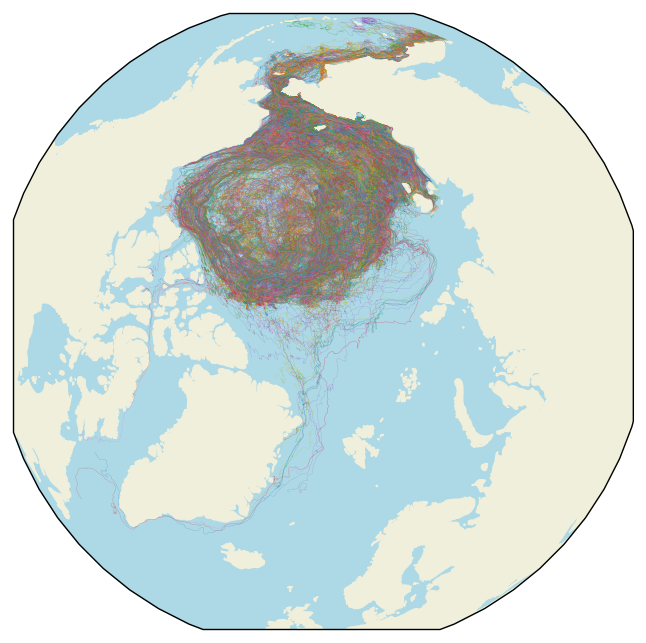

In [35]:
plt.figure(figsize = [8,8])
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=90, satellite_height=4e6))
ax.add_feature(plot_functions.ocean_50m)
ax.add_feature(plot_functions.land_50m)
ax.set_extent([-180,180,50,90],  ccrs.PlateCarree())

for paths in np.arange(0,10950, 7):
    ax.plot(be_ice.lon.isel(traj=paths), be_ice.lat.isel(traj=paths), transform=ccrs.Geodetic(), linewidth=.1)



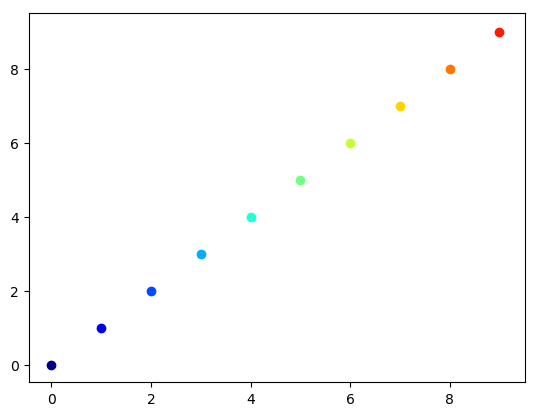

In [78]:
fake_data = np.arange(10)

stepsize = len(cmaplist)//10

for i in range(10):
    plt.scatter(fake_data[i], fake_data[i], color = cmaplist[stepsize*i])

In [166]:
ds0 = pd.DataFrame(data=np.array(all_layers_core[0]), columns=['i', 'j', 'sit_i', 'sit_j', 'lon_i', 'lat_i', 'lon_j', 'lat_j'])
ds1 = pd.DataFrame(data=np.array(all_layers_core[1]), columns=['i', 'j', 'sit_i', 'sit_j', 'lon_i', 'lat_i', 'lon_j', 'lat_j'])


ds_layer_list = []
layer_labels  = []
for i in range(6):
    y =pd.DataFrame(data=np.array(all_layers_core[i]), columns=['i', 'j', 'sit_i', 'sit_j', 'lon_i', 'lat_i', 'lon_j', 'lat_j'])
    ds_layer_list.append(y)
    layer_labels.append(str(int(y.sit_i[0]//.1)))
   
    
ds_all_x_test = pd.concat(ds_layer_list, keys=layer_labels)



In [175]:
ds_all_x_test.index.levels


FrozenList([[u'14', u'15', u'16', u'17', u'18', u'19'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

In [167]:
ds_all_x_test

i       j  sit_i     sit_j  lon_i  lat_i       lon_j      lat_j
14 0   145.0  1173.0   1.45  1.449894 -140.0   85.0 -166.204361  80.739624
   1   146.0  1164.0   1.46  1.459651 -140.0   85.0 -168.705063  80.458801
   2   147.0  1159.0   1.47  1.468535 -140.0   85.0 -170.078888  80.707321
   3   148.0  1154.0   1.48  1.479875 -140.0   85.0 -169.065765  81.103493
   4   149.0  1151.0   1.49  1.487839 -140.0   85.0 -169.619171  81.370079
   5   150.0  1147.0   1.50  1.499805 -140.0   85.0 -168.587219  81.583076
15 0   151.0  1144.0   1.51  1.509758 -140.0   85.0 -170.196243  81.758904
   1   152.0  1142.0   1.52  1.516845 -140.0   85.0 -170.614868  81.860382
   2   153.0  1139.0   1.53  1.528112 -140.0   85.0 -171.351746  81.951485
   3   154.0  1137.0   1.54  1.536021 -140.0   85.0 -171.580231  81.966011
   4   155.0  1134.0   1.55  1.548433 -140.0   85.0 -169.616318  82.080101
   5   156.0  1132.0   1.56  1.557042 -140.0   85.0 -168.081345  82.139862
   6   157.0  1130.0   1.57  1.565897 -140.0   85.0 -166.570099  82.110687
   7   158.0  1127.0   1.58  1.579616 -140.0   85.0 -166.872818  82.145256
   8   159.0  1125.0   1.59  1.589033 -140.0   85.0 -167.132904  82.086250
16 0   160.0  1123.0   1.60  1.598648 -140.0   85.0 -167.670273  82.128014
   1   161.0  1121.0   1.61  1.608446 -140.0   85.0 -168.189194  82.076553
   2   162.0  1119.0   1.62  1.618412 -140.0   85.0 -167.118973  81.965553
   3   163.0  1117.0   1.63  1.628531 -140.0   85.0 -165.790375  82.040138
   4   164.0  1115.0   1.64  1.638785 -140.0   85.0 -166.086243  82.152756
   5   165.0  1113.0   1.65  1.649162 -140.0   85.0 -165.349777  82.118088
   6   166.0  1111.0   1.66  1.659655 -140.0   85.0 -165.174225  82.136299
   7   167.0  1110.0   1.67  1.664945 -140.0   85.0 -165.346130  82.165260
   8   168.0  1108.0   1.68  1.675610 -140.0   85.0 -165.087692  82.036804
   9   169.0  1106.0   1.69  1.686377 -140.0   85.0 -164.085068  81.944733
   10  170.0  1104.0   1.70  1.697231 -140.0   85.0 -162.534149  81.982399
17 0   171.0  1102.0   1.71  1.708160 -140.0   85.0 -161.471985  82.112152
   1   172.0  1100.0   1.72  1.719153 -140.0   85.0 -160.169739  82.204216
   2   173.0  1099.0   1.73  1.724671 -140.0   85.0 -159.269455  82.242508
   3   174.0  1097.0   1.74  1.735743 -140.0   85.0 -157.666031  82.381714
   4   175.0  1095.0   1.75  1.746861 -140.0   85.0 -156.671158  82.503822
   5   176.0  1093.0   1.76  1.758020 -140.0   85.0 -155.124069  82.457802
   6   177.0  1091.0   1.77  1.769217 -140.0   85.0 -154.587814  82.443993
   7   178.0  1090.0   1.78  1.774830 -140.0   85.0 -154.191315  82.348091
   8   179.0  1088.0   1.79  1.786084 -140.0   85.0 -153.772964  82.247955
   9   180.0  1086.0   1.80  1.797377 -140.0   85.0 -153.080460  82.029320
18 0   181.0  1084.0   1.81  1.808717 -140.0   85.0 -151.652893  81.936478
   1   182.0  1083.0   1.82  1.814405 -140.0   85.0 -151.000793  81.874008
   2   183.0  1081.0   1.83  1.825819 -140.0   85.0 -150.486526  81.813644
   3   184.0   794.0   1.84  1.839568 -140.0   85.0 -140.876556  76.759682
   4   185.0   784.0   1.85  1.849426 -140.0   85.0 -142.538879  77.059235
   5   186.0   778.0   1.86  1.858697 -140.0   85.0 -144.081924  76.640373
   6   187.0   773.0   1.87  1.868470 -140.0   85.0 -147.168243  76.469490
   7   188.0   418.0   1.88  1.879034 -140.0   85.0 -169.766113  77.597099
   8   189.0   411.0   1.89  1.889602 -140.0   85.0 -170.409515  78.028870
19 0   190.0   407.0   1.90  1.897929 -140.0   85.0 -169.874435  77.866608
   1   191.0   403.0   1.91  1.907846 -140.0   85.0 -169.651825  77.808205
   2   192.0   399.0   1.92  1.919290 -140.0   85.0 -169.386230  77.952690
   3   193.0   396.0   1.93  1.928805 -140.0   85.0 -169.407089  78.217262

In [146]:
np.shape(all_layers_core)

(6,)

In [148]:
np.array(all_layers_core[0])

array([[ 145.        , 1173.        ,    1.45      ,    1.44989395,
        -140.        ,   85.        , -166.20436096,   80.73962402],
       [ 146.        , 1164.        ,    1.46      ,    1.45965087,
        -140.        ,   85.        , -168.70506287,   80.45880127],
       [ 147.        , 1159.        ,    1.47      ,    1.46853495,
        -140.        ,   85.        , -170.07888794,   80.70732117],
       [ 148.        , 1154.        ,    1.48      ,    1.47987473,
        -140.        ,   85.        , -169.06576538,   81.10349274],
       [ 149.        , 1151.        ,    1.49      ,    1.48783863,
        -140.        ,   85.        , -169.61917114,   81.37007904],
       [ 150.        , 1147.        ,    1.5       ,    1.49980485,
        -140.        ,   85.        , -168.58721924,   81.58307648]])

In [106]:
ds0

i       j  sit_i     sit_j  lon_i  lat_i       lon_j      lat_j
0  145.0  1173.0   1.45  1.449894 -140.0   85.0 -166.204361  80.739624
1  146.0  1164.0   1.46  1.459651 -140.0   85.0 -168.705063  80.458801
2  147.0  1159.0   1.47  1.468535 -140.0   85.0 -170.078888  80.707321
3  148.0  1154.0   1.48  1.479875 -140.0   85.0 -169.065765  81.103493
4  149.0  1151.0   1.49  1.487839 -140.0   85.0 -169.619171  81.370079
5  150.0  1147.0   1.50  1.499805 -140.0   85.0 -168.587219  81.583076

In [123]:
layer_id = np.array([ds0.sit_i/.1, ds1.sit_i/.1])

In [143]:
ds_all=pd.concat( [ds0,ds1], keys = ["Hello_14","hello_15"])

In [149]:
ds_all

i       j  sit_i     sit_j  lon_i  lat_i       lon_j  \
Hello_14 0  145.0  1173.0   1.45  1.449894 -140.0   85.0 -166.204361   
         1  146.0  1164.0   1.46  1.459651 -140.0   85.0 -168.705063   
         2  147.0  1159.0   1.47  1.468535 -140.0   85.0 -170.078888   
         3  148.0  1154.0   1.48  1.479875 -140.0   85.0 -169.065765   
         4  149.0  1151.0   1.49  1.487839 -140.0   85.0 -169.619171   
         5  150.0  1147.0   1.50  1.499805 -140.0   85.0 -168.587219   
hello_15 0  151.0  1144.0   1.51  1.509758 -140.0   85.0 -170.196243   
         1  152.0  1142.0   1.52  1.516845 -140.0   85.0 -170.614868   
         2  153.0  1139.0   1.53  1.528112 -140.0   85.0 -171.351746   
         3  154.0  1137.0   1.54  1.536021 -140.0   85.0 -171.580231   
         4  155.0  1134.0   1.55  1.548433 -140.0   85.0 -169.616318   
         5  156.0  1132.0   1.56  1.557042 -140.0   85.0 -168.081345   
         6  157.0  1130.0   1.57  1.565897 -140.0   85.0 -166.570099   
         7  158.0  1127.0   1.58  1.579616 -140.0   85.0 -166.872818   
         8  159.0  1125.0   1.59  1.589033 -140.0   85.0 -167.132904   

                lat_j  
Hello_14 0  80.739624  
         1  80.458801  
         2  80.707321  
         3  81.103493  
         4  81.370079  
         5  81.583076  
hello_15 0  81.758904  
         1  81.860382  
         2  81.951485  
         3  81.966011  
         4  82.080101  
         5  82.139862  
         6  82.110687  
         7  82.145256  
         8  82.086250